In [4]:
import numpy as np
import copy
import matplotlib.pyplot as plt

import scipy
from scipy import signal,stats
from scipy.fft import rfft,rfftfreq
from scipy import stats

import seaborn as sns
import pandas as pd
import sklearn
import seaborn as sns
from tabulate import tabulate

In [5]:
# # Create function to load data 

filenames_ana = ['Happy_4.txt', 'Tense_3.txt', 'Relaxed_4.txt', 'Sad_5.txt']  # Happy (9,9), Sad (3,3)

filenames_john = ['Erotic_1.txt', 'Fear2_1.txt', 'Erotic_5.txt', 'Fear2_6.txt'] # Happy (8,7), Sad (2,6)

filenames_jenny = ['Erotic_2.txt', 'Fear2_2.txt', 'Scenery_4.txt', 'Sadness_2.txt'] # Happy (8,7), Sad (3,2)

filenames_ale = ['Erotic_3.txt', 'Fear_2.txt', 'Scenery_4.txt', 'Sadness_2.txt'] # Happy (9,9), Sad (2,2)


ana_data = {'Happy':[],
              'Tense':[],
              'Relaxed':[],
              'Sad':[]}

john_data = {'Happy':[],
              'Tense':[],
              'Relaxed':[],
              'Sad':[]}

jenny_data = {'Happy':[],
              'Tense':[],
              'Relaxed':[],
              'Sad':[]}

ale_data = {'Happy':[],
              'Tense':[],
              'Relaxed':[],
              'Sad':[]}


channels = ['0','1','2','3']

def load_data(file_path):
    data_file = pd.read_csv(file_path, comment='%', header=0, delimiter=',', engine='python') 
    data = data_file[[' EXG Channel 0', ' EXG Channel 1', ' EXG Channel 2', ' EXG Channel 3']].values.T
    return data

# # Load Ana data
print('Ana Data:\n')
for idx, (state, _) in enumerate(ana_data.items()):
    ana_data[state] = load_data(f'.../Subject 5 Ana/{filenames_ana[idx]}')
    print(f'{state} Data Shape: {ana_data[state].shape}')

# # Load John data
print('\nJohn Data:\n')
for idx, (state, _) in enumerate(john_data.items()):
    john_data[state] = load_data(f'.../Subject 4 John/{filenames_john[idx]}')
    print(f'{state} Data Shape: {john_data[state].shape}')
    
# # Load Jenny data
print('\nJenny Data:\n')
for idx, (state, _) in enumerate(jenny_data.items()):
    jenny_data[state] = load_data(f'.../Subject 2 Jenny/{filenames_jenny[idx]}')
    print(f'{state} Data Shape: {jenny_data[state].shape}')

# # Load Ale data
print('\nAle Data:\n')
for idx, (state, _) in enumerate(ale_data.items()):
    ale_data[state] = load_data(f'.../Subject 1 Ale/{filenames_ale[idx]}')
    print(f'{state} Data Shape: {ale_data[state].shape}')

ana_data = {state : ana_data[state][:,int(10*256):int(data.shape[1]-10*256)] for state,data in ana_data.items()} # Remove last 10 seconds of ana data (artifact)
john_data = {state : john_data[state][:,int(10*256):int(data.shape[1]-10*256)] for state,data in john_data.items()} # Remove last 10 seconds of john data (artifact)
jenny_data = {state : jenny_data[state][:,int(10*256):int(data.shape[1]-10*256)] for state,data in jenny_data.items()} # Remove last 10 seconds of jenny data (artifact)
ale_data = {state : ale_data[state][:,int(10*256):int(data.shape[1]-10*256)] for state,data in ale_data.items()} # Remove last 10 seconds of ale data (artifact)

Ana Data:

Happy Data Shape: (4, 34321)
Tense Data Shape: (4, 44704)
Relaxed Data Shape: (4, 25192)
Sad Data Shape: (4, 27158)

John Data:

Happy Data Shape: (4, 24397)
Tense Data Shape: (4, 27662)
Relaxed Data Shape: (4, 25028)
Sad Data Shape: (4, 34747)

Jenny Data:

Happy Data Shape: (4, 24954)
Tense Data Shape: (4, 28930)
Relaxed Data Shape: (4, 22785)
Sad Data Shape: (4, 26425)

Ale Data:

Happy Data Shape: (4, 24967)
Tense Data Shape: (4, 23872)
Relaxed Data Shape: (4, 22883)
Sad Data Shape: (4, 27675)


In [6]:
# # Remove outliers by using interpolation

for state, data in ana_data.items():
    for i, ch in enumerate(data):
        ana_mask = abs(ch - np.mean(ch)) > 2 * np.std(ch) # Identify outliers
        
        # Replace outliers using linear interpolation
        indices = np.arange(len(ch)) 
        ch_cleaned = np.copy(ch)
        ch_cleaned[ana_mask] = np.interp(indices[ana_mask], indices[~ana_mask], ch[~ana_mask])
        
        ana_data[state][i] = ch_cleaned


for state, data in john_data.items():
    for i, ch in enumerate(data):
        john_mask = abs(ch - np.mean(ch)) > 2 * np.std(ch) 
        
        indices = np.arange(len(ch)) 
        ch_cleaned = np.copy(ch)
        ch_cleaned[john_mask] = np.interp(indices[john_mask], indices[~john_mask], ch[~john_mask])
        
        john_data[state][i] = ch_cleaned

for state, data in jenny_data.items():
    for i, ch in enumerate(data):
        jenny_mask = abs(ch - np.mean(ch)) > 2 * np.std(ch) # Identify outliers
        
        # Replace outliers using linear interpolation
        indices = np.arange(len(ch)) 
        ch_cleaned = np.copy(ch)
        ch_cleaned[jenny_mask] = np.interp(indices[jenny_mask], indices[~jenny_mask], ch[~jenny_mask])
        
        jenny_data[state][i] = ch_cleaned


for state, data in ale_data.items():
    for i, ch in enumerate(data):
        ale_mask = abs(ch - np.mean(ch)) > 2 * np.std(ch) 
        
        indices = np.arange(len(ch)) 
        ch_cleaned = np.copy(ch)
        ch_cleaned[ale_mask] = np.interp(indices[ale_mask], indices[~ale_mask], ch[~ale_mask])
        
        ale_data[state][i] = ch_cleaned


In [7]:
# # Set sampling frequency
fs = 200

# Apply a bandpass filter between 4-60 Hz to each set of data
filt_coef = signal.firwin(numtaps=(int(3*fs/4)), cutoff=(4,55), fs=fs, pass_zero=False)

# # Filter ana data
for state, data in ana_data.items():
    ana_data[state] = signal.lfilter(filt_coef,1.0,data, axis=-1)

# # Filter john data
for state, data in john_data.items():
    john_data[state] = signal.lfilter(filt_coef,1.0,data, axis=-1)

# # Filter jenny data
for state, data in jenny_data.items():
    jenny_data[state] = signal.lfilter(filt_coef,1.0,data, axis=-1)

# # Filter ale data
for state, data in ale_data.items():
    ale_data[state] = signal.lfilter(filt_coef,1.0,data, axis=-1)


In [8]:
# # Grab the right mastoid region data only from Luisa and Antonio

ana_data_rm = {state : ana_data[state][0,:] for state in ana_data.keys()}

john_data_rm = {state : john_data[state][0,:] for state in john_data.keys()}

jenny_data_rm = {state : jenny_data[state][0,:] for state in jenny_data.keys()}

ale_data_rm = {state : ale_data[state][0,:] for state in ale_data.keys()}

print(ale_data_rm['Sad'].shape)

(22555,)


In [9]:
# # Create plotting functon for time and freq domain and plot Luisa data
def plot_subject_data(data,fs,channels,power_ylim=None):
    """
    Plot time-domain and power spectrum for each emotional state in a subjects dataset

    Parameters:
    data : dict
        Dictionary containing EEG data for each emotional state
    fs : int
        Sampling freq
    channels : list
        List of channel labels

    Returns:
    freq_domain_data : dict
        Dictionary containing power spectra and frequencies for each state and channel
    """
    n_states = len(data)
    freq_domain_data = {} # Initialze dict so you can store freq domain info for each state and each channel
    fig, axes = plt.subplots(2, n_states, figsize=(30, 16))
    fig.suptitle("Time-Domain and Power Spectra for All States", fontsize=24,fontweight='bold')


    for col, (state, data) in enumerate(data.items()):
        # Create time vector for current state
        t_vec = np.arange(2, data.size/fs, 1/fs) # chop out first couple seconds for now, antonio data still shows early artifact
        
        # Initialize storage for this state's frequency data
        freq_domain_data[state] = {"frequencies": None, "power_spectra": []}

        # Plot time domain data
        
        axes[0,col].plot(t_vec, data[2*fs:], label=f'Channel 0' if col == 0 else None)
        axes[0,col].set_title(f'{state} (Time Domain)', fontsize=16,fontweight='bold')
        axes[0,col].set_xlabel('Time (s)', fontsize=16,fontweight='bold')
        axes[0,col].set_ylabel('Voltage (uV)', fontsize=16,fontweight='bold')
        axes[0,col].set_xlim([None, t_vec[-1]+1/fs])
        axes[0,col].tick_params(axis='both', which='major', labelsize=16)

        # Plot frequency domain data (power spectrum)
        
        ft = abs(rfft(data))
        ps = ft**2
        freqs = rfftfreq(data.size, d=1/fs)
        axes[1,col].plot(freqs, ps)

        # Store frequency and power spectrum for each channel
        freq_domain_data[state]["frequencies"] = freqs
        freq_domain_data[state]["power_spectra"].append(ps)


        axes[1,col].set_title(f'{state} (Power Spectrum)', fontsize=16,fontweight='bold')
        axes[1,col].set_xlabel('Frequency (Hz)', fontsize=16,fontweight='bold')
        axes[1,col].set_ylabel('Power (Log Scale)', fontsize=16,fontweight='bold')
        axes[1,col].set_xlim([4, 55])
        axes[1,col].set_yscale('log')
        axes[1,col].grid(True, which='major')
        if power_ylim:
            axes[1, col].set_ylim(power_ylim) 
        axes[1, col].tick_params(axis='both', which='major', labelsize=16)

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 0.5), fontsize=20, shadow=True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.show()

    return freq_domain_data


In [10]:
# # Plot STFT of only Mastoid Region Channel

# # Create function to display STFT for each channel in each state

def plot_rmastoid_stft(data,name,nperseg,vmax=None,fs=fs):

    n_states = len(data)   
    n_channels = len(next(iter(data.values())))

    fig,ax = plt.subplots(1,4,figsize=(20,4))
    fig.suptitle(f"{name}'s Time-Frequency (STFT) Plot for Right Mastoid Channel", fontsize=10,fontweight='bold')


    # Plot the STFT for channel 0 - mastoid region
    for col, (state, ch) in enumerate(data.items()):
        f_spg,t_spg,spg = signal.spectrogram(x=ch,nperseg=nperseg,noverlap=int(0.25*nperseg),fs=fs)

        if vmax == None:
            cb = ax[col].pcolormesh(t_spg,f_spg,spg, shading='auto',cmap='viridis',vmin=0)
        else:
            cb = ax[col].pcolormesh(t_spg,f_spg,spg, shading='auto',cmap='viridis',vmin=0,vmax=vmax)
            
        ax[col].set(title=f'{state}',xlabel='Time (s)',
                          ylabel='Frequency (Hz)',ylim=[4,55])
    
        if col == 3:
            plt.colorbar(cb, ax=ax[col], label='Power')
    
    plt.tight_layout()
    plt.show()


In [11]:
# # First calculate average power in frequency bands 

def calc_avg_band_power(data,nperseg, fs=fs):

    freq_ranges = {
    'theta':[4,8],
    'alpha1':[8,10],
    'alpha2':[10,12],
    'beta1':[12,18],
    'beta2':[18,24],
    'beta3':[24,30],
    'gamma1':[30,38],
    'gamma2':[38,46],
    'gamma3':[46,54]
    }

    state_data = {'Happy':[],
              'Tense':[],
              'Relaxed':[],
              'Sad':[]}
    
    subject_state_avg_power = {state: {} for state in state_data.keys()}

    # Loop through each state 
    for state, _ in subject_state_avg_power.items():
       
       # Obtain the PSD values for right mastoid channel in each state
       f_psd, psd = signal.welch(x=data[state],nperseg=nperseg,noverlap=int(nperseg*0.25),fs=fs)

       # Loop through frequency band ranges and obtain mean power for each band in the current state
       for band, (f_min, f_max) in freq_ranges.items():     
            band_mask = np.logical_and(f_psd >= f_min, f_psd <= f_max)
            subject_state_avg_power[state][band] = psd[band_mask].mean()  


    return subject_state_avg_power


In [12]:
# # Create function to plot the results from mean power band

def plot_avg_power(subject_state_avg_power,name):
    df = pd.DataFrame(subject_state_avg_power).T 
    df.plot(kind='bar', figsize=(10, 5), width=0.8, colormap='jet')
    plt.title(f"{name}'s Average Power Across Frequency Bands for Each State Bar Plot - Right Mastoid")
    plt.xlabel("Frequency Bands")
    plt.ylabel("Average Power")
    plt.xticks(rotation=45)
    plt.legend(title="States")
    plt.tight_layout()
    plt.show()

In [13]:
# # Create function for heatmap

def plot_avg_power_heatmap(subject_state_avg_power, name):
    df = pd.DataFrame(subject_state_avg_power).T 
    plt.figure(figsize=(9, 5))
    sns.heatmap(df, annot=True, cmap="viridis", fmt=".2f")
    plt.title(f"{name}'s Average Power Across Frequency Bands and States Heatmap - Right Mastoid")
    plt.xlabel("Frequency Bands")
    plt.ylabel("States")
    plt.tight_layout()
    plt.show()


In [14]:
def plot_arousal_valence(subject_state_avg_power,name):
    # Group states by arousal and valence
    arousal_groups = {
        'High Arousal': ['Happy', 'Tense'],
        'Low Arousal': ['Relaxed', 'Sad']
    }
    valence_groups = {
        'High Valence': ['Happy', 'Relaxed'],
        'Low Valence': ['Tense', 'Sad']
    }

    # Calculate average power for each group
    arousal_avg = {group: {} for group in arousal_groups}
    valence_avg = {group: {} for group in valence_groups}

    for group, states in arousal_groups.items():
        for band in subject_state_avg_power['Happy']:
            arousal_avg[group][band] = np.mean([subject_state_avg_power[state][band] for state in states])

    for group, states in valence_groups.items():
        for band in subject_state_avg_power['Happy']:
            valence_avg[group][band] = np.mean([subject_state_avg_power[state][band] for state in states])

    # Plot High vs Low Arousal
    fig, ax = plt.subplots(figsize=(10,5))
    bands = list(subject_state_avg_power['Happy'].keys())
    ax.bar(bands, arousal_avg['High Arousal'].values(), color='blue', alpha=0.8, label='High Arousal')
    ax.bar(bands, arousal_avg['Low Arousal'].values(), color='orange', alpha=0.8, label='Low Arousal')
    ax.set_title(f"{name}'s Average Power by Arousal Levels")
    ax.set_xlabel("Frequency Bands")
    ax.set_ylabel("Average Power")
    ax.set_xticks(range(len(bands)))
    ax.set_xticklabels(bands, rotation=45)
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Plot High vs Low Valence
    fig, ax = plt.subplots(figsize=(10,5))
    ax.bar(bands, valence_avg['High Valence'].values(), color='green', alpha=0.8, label='High Valence')
    ax.bar(bands, valence_avg['Low Valence'].values(), color='red', alpha=0.8, label='Low Valence')
    ax.set_title(f"{name}'s Average Power by Valence Levels")
    ax.set_xlabel("Frequency Bands")
    ax.set_ylabel("Average Power")
    ax.set_xticks(range(len(bands)))
    ax.set_xticklabels(bands, rotation=45)
    ax.legend()
    plt.tight_layout()
    plt.show()

In [15]:
# # Create function for all temporal variability metrics 

def calc_temporal_metrics(data,nperseg,fs=fs):
    
    freq_ranges = {
    'theta': [4, 8],
    'alpha1': [8, 10],
    'alpha2': [10, 12],
    'beta1': [12, 18],
    'beta2': [18, 24],
    'beta3': [24, 30],
    'gamma1': [30, 38],
    'gamma2': [38, 46],
    'gamma3': [46, 54]
}
    
    metrics = {state: {} for state in data.keys()}
    
    for state, channel in data.items():
        f, t, spg = signal.spectrogram(channel, fs=fs, nperseg=nperseg, noverlap=int(fs*0.25))
        
        for band, (f_min, f_max) in freq_ranges.items():
            band_mask = np.logical_and(f >= f_min, f <= f_max)
            band_power = spg[band_mask].mean(axis=0)
            
            # Calculate metrics
            metrics[state][band] = {
                'std dev': np.std(band_power),                     # Standard deviation
                'range': np.max(band_power) - np.min(band_power),  # Range
                'cv': (np.std(band_power) / np.mean(band_power)) * 100,  # Coefficient of Variation
                'skewness': stats.skew(band_power),                     # Skewness
                'kurtosis': stats.kurtosis(band_power),                 # Kurtosis
                'mad': np.median(np.abs(band_power - np.median(band_power)))  # Median Absolute Deviation
            }
    

    '''

    Notes:
    -These are all temporal metrics grouped together under the broader category of temporal variability, with the first metric (SDV) being
    the primary measure of variability. The additional metrics are complementary and and help to explore different aspects of variability
    in the data. 

    -Standard deviation of the 1D array containing avg power of a band along time axis measures average fluctuations/variance of that frequency
    over time. We can see how variable/how much fluctuation there is for each frequency band. We would expect high arousal to have greater
    fluctuation/variability because of hypsersenstivity to emotions(heightened neural activity) and low arousal to have less variability due to
    being in a calmer state.

    Range: Focuses on extreme differences (peak to peak variability).

    Coefficient of Variation: Normalizes variability relative to the mean, allowing comparisons across frequency bands or states.

    Skewness: Adds information about the direction of variability (like transient bursts vs. baseline activity).

    Kurtosis: Highlights whether variability is caused by extreme outliers or steady fluctuations.
    
    Median Absolute Deviation: A robust non-parametric variability measure that's less sensitive to outliers than standard deviation.

    '''



    return metrics


In [16]:
def plot_temporal_metrics(metrics,name):
    states = list(metrics.keys())
    bands = list(next(iter(metrics.values())).keys())
    metric_names = list(next(iter(next(iter(metrics.values())).values())).keys())

    for metric_name in metric_names:
        # Create a new figure for each metric
        fig, ax = plt.subplots(figsize=(10,5))
        x = np.arange(len(bands))
        width = 0.2  # Width of the bars

        # Plot bars for each state
        for i, state in enumerate(states):
            values = [metrics[state][band][metric_name] for band in bands]
            ax.bar(x + i * width, values, width, label=state)

        # Set titles and labels
        ax.set_title(f"{name} - Temporal {metric_name.capitalize()} Across Frequency Bands and States")
        ax.set_xlabel("Frequency Bands")
        ax.set_ylabel(metric_name.capitalize())
        ax.set_xticks(x + width * (len(states) - 1) / 2)
        ax.set_xticklabels(bands, rotation=45)
        ax.legend(loc="upper right")
        ax.grid(axis="y", linestyle="--", alpha=0.7)

        plt.tight_layout()
        plt.show()


In [17]:
def calc_band_power_ratios(subject_state_avg_power):

    copy_state_avg_power = copy.deepcopy(subject_state_avg_power)

    for state in copy_state_avg_power.keys():
        copy_state_avg_power[state]['alpha'] = np.mean([copy_state_avg_power[state]['alpha1'],copy_state_avg_power[state]['alpha2']])
        copy_state_avg_power[state]['beta'] = np.mean([copy_state_avg_power[state]['beta1'],
                                                          copy_state_avg_power[state]['beta2'],copy_state_avg_power[state]['beta3']])
        copy_state_avg_power[state]['gamma'] = np.mean([copy_state_avg_power[state]['gamma1'],
                                                           copy_state_avg_power[state]['gamma2'],copy_state_avg_power[state]['gamma3']])

    band_power_ratios = {state: {} for state in copy_state_avg_power.keys()}

    sub_bands = ['beta','beta1','beta2','beta3','gamma','gamma1','gamma2','gamma3']

    for state in band_power_ratios.keys():
        for band in sub_bands:
            band_ratio = f'{band}/alpha'
            band_power_ratios[state][band_ratio] = copy_state_avg_power[state][band]/copy_state_avg_power[state]['alpha']


    return band_power_ratios

In [18]:
def plot_band_ratio_heatmap(subject_band_ratios, name):
    df = pd.DataFrame(subject_band_ratios).T 
    fig,ax = plt.subplots(figsize=(10,5))
    sns.heatmap(df, annot=True, cmap="viridis", fmt=".2f")
    ax.set(title=f"{name}'s Band Power Ratios Heatmap - Right Mastoid",
           xlabel="Frequency Bands",ylabel="States")
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot Ana Data

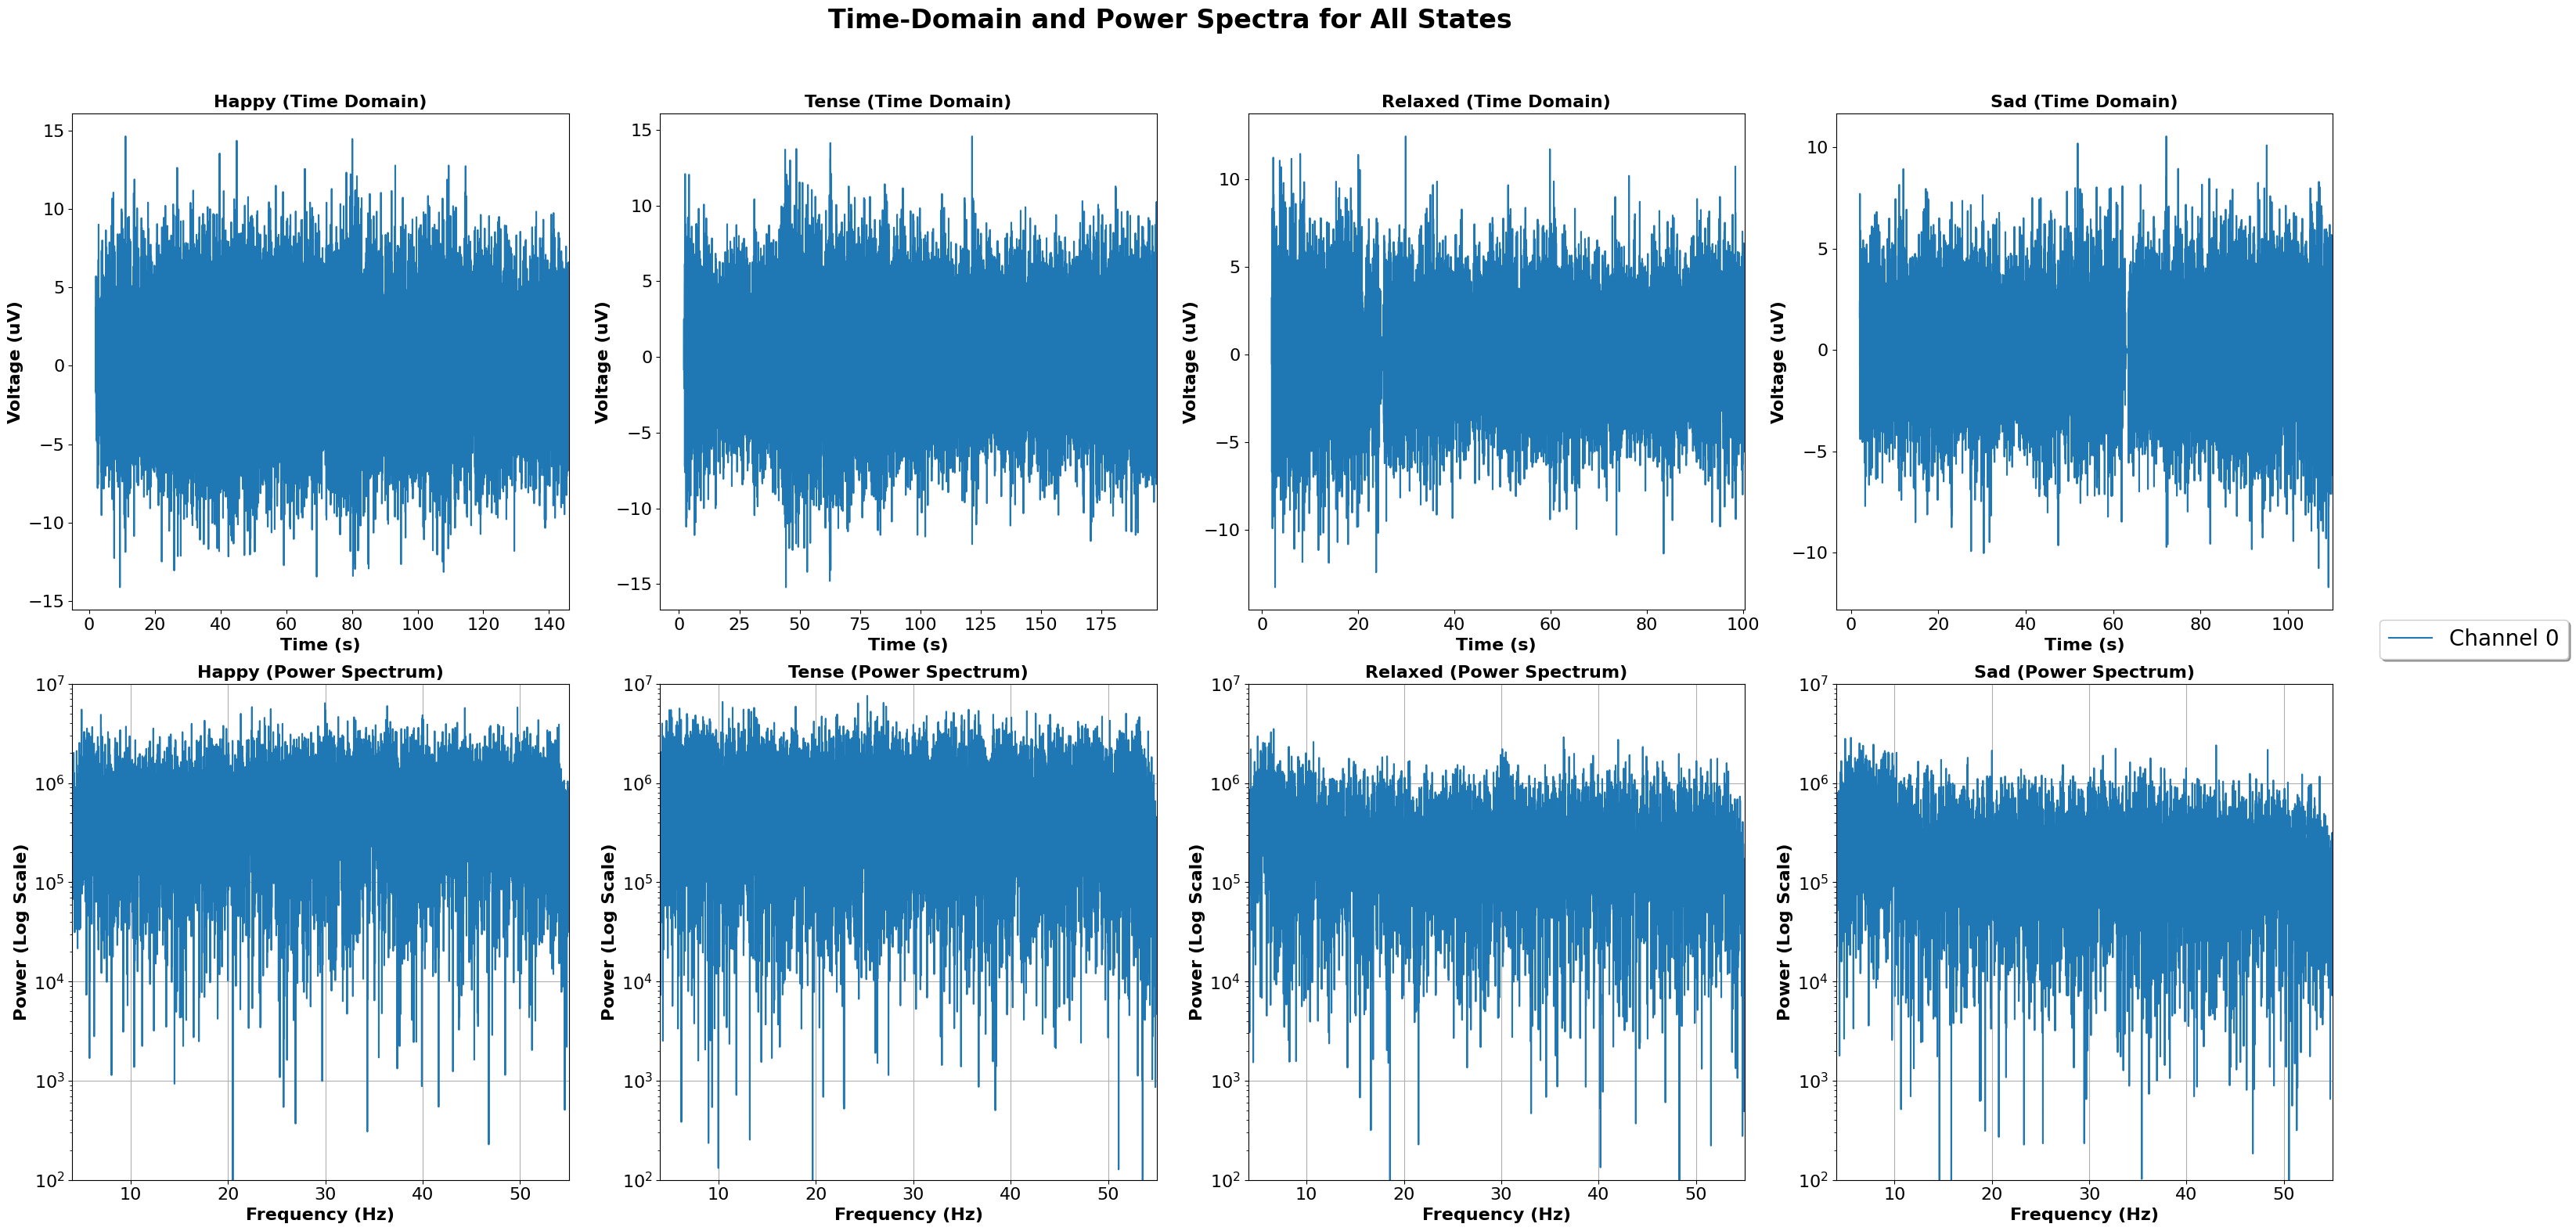

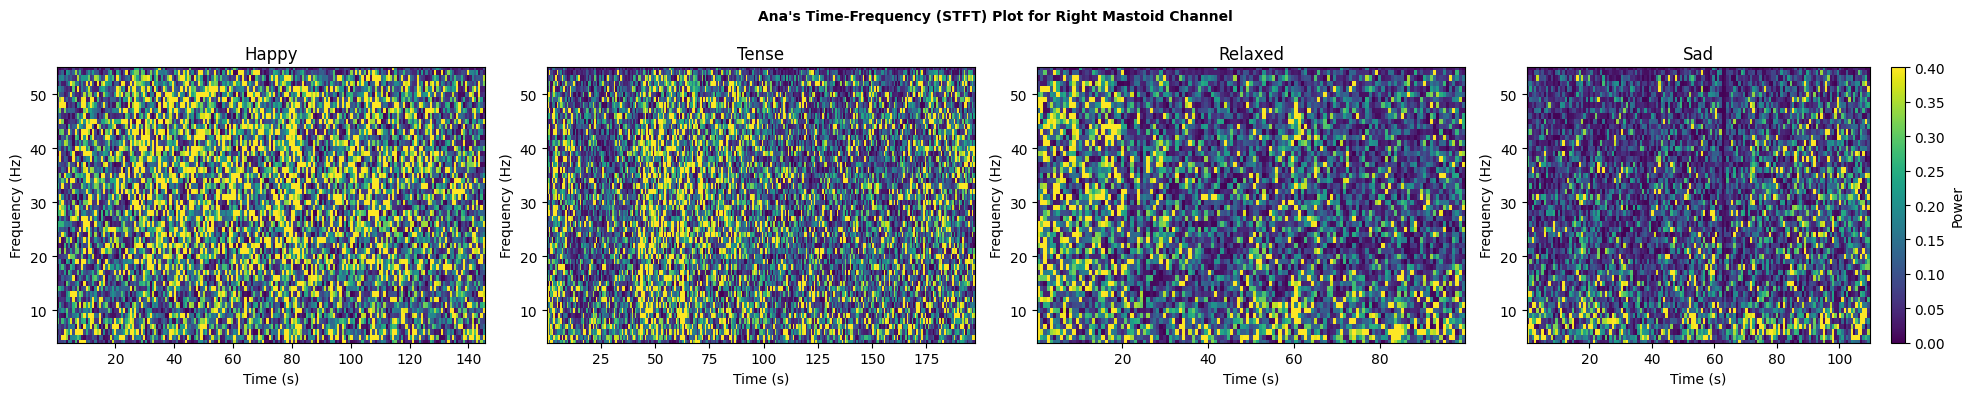

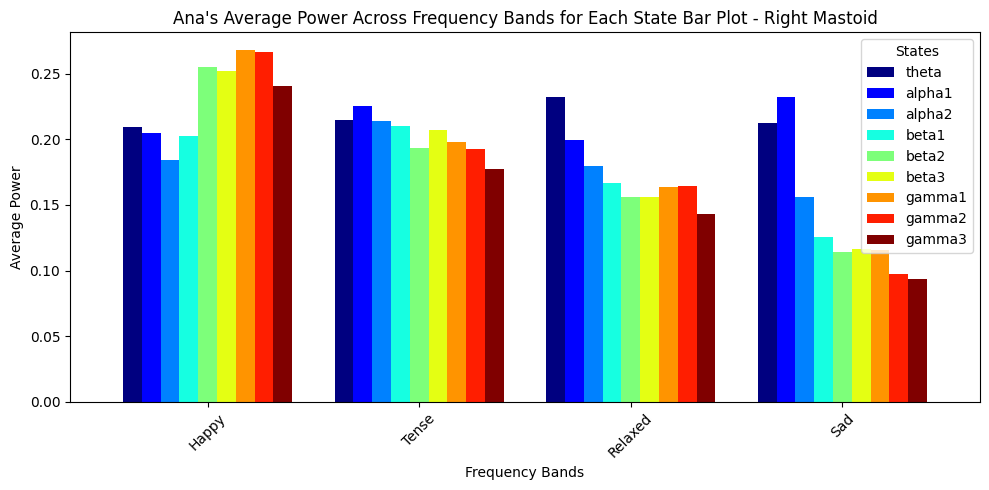

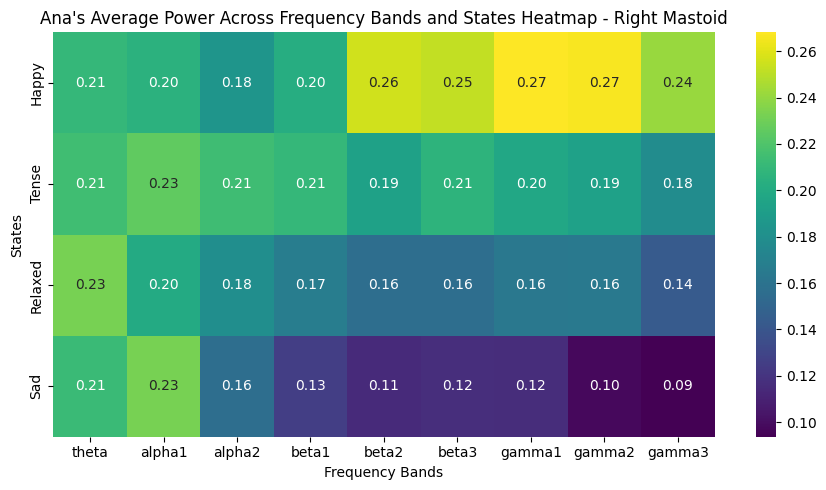

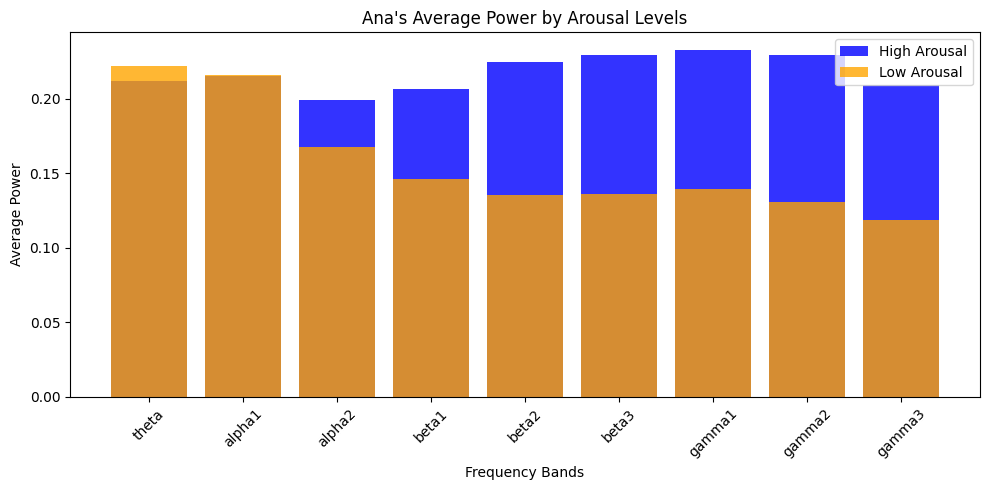

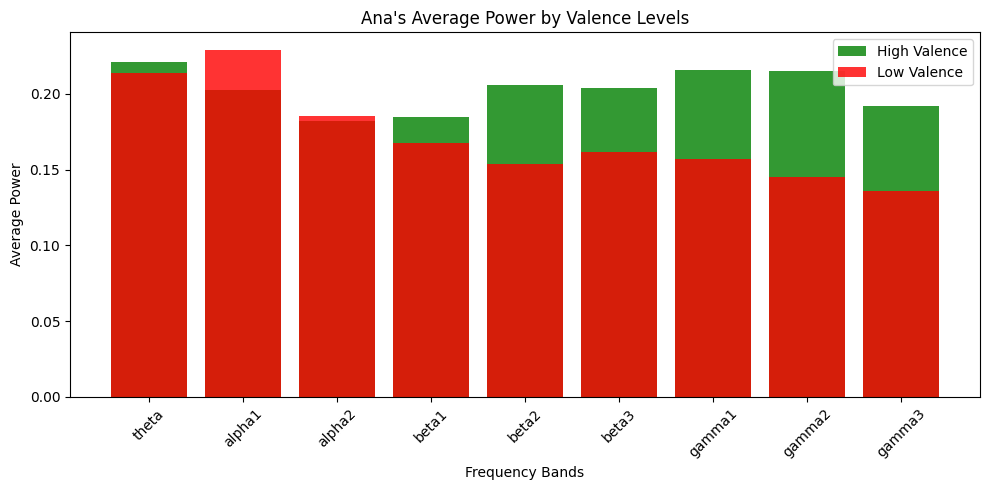

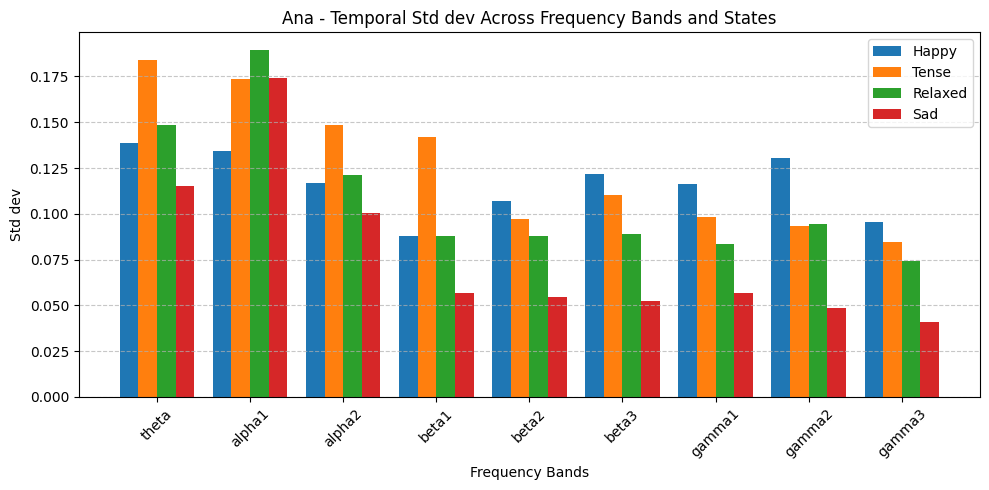

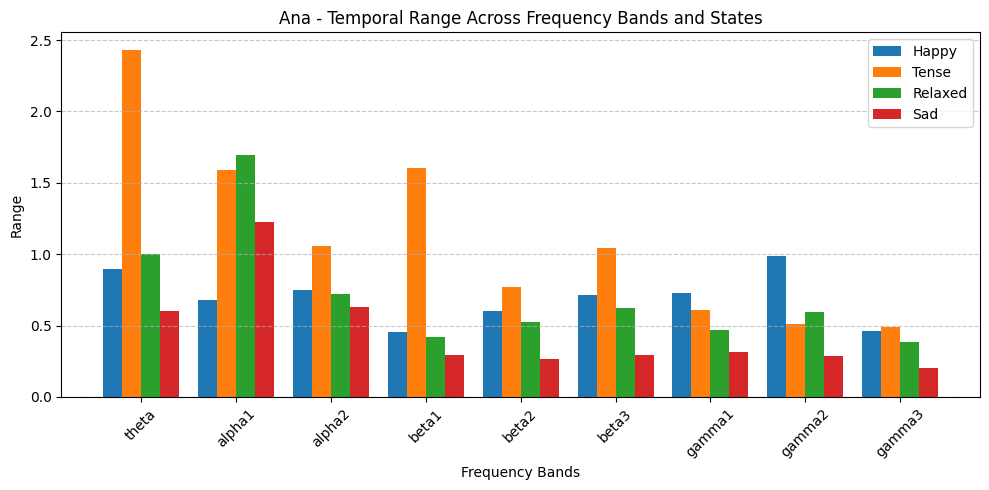

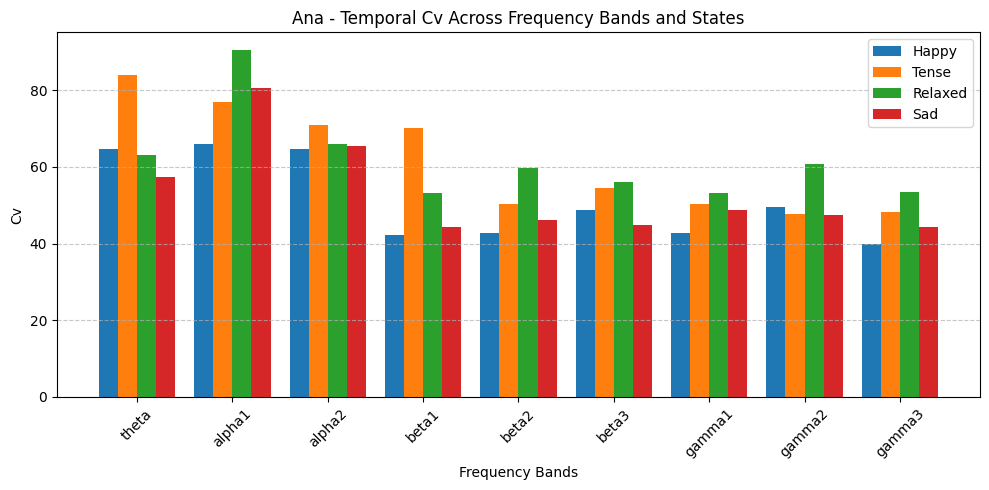

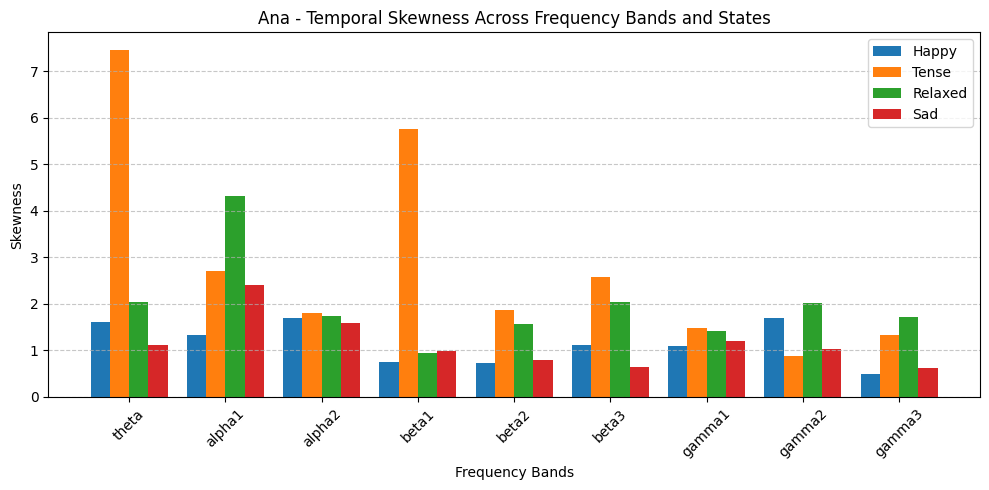

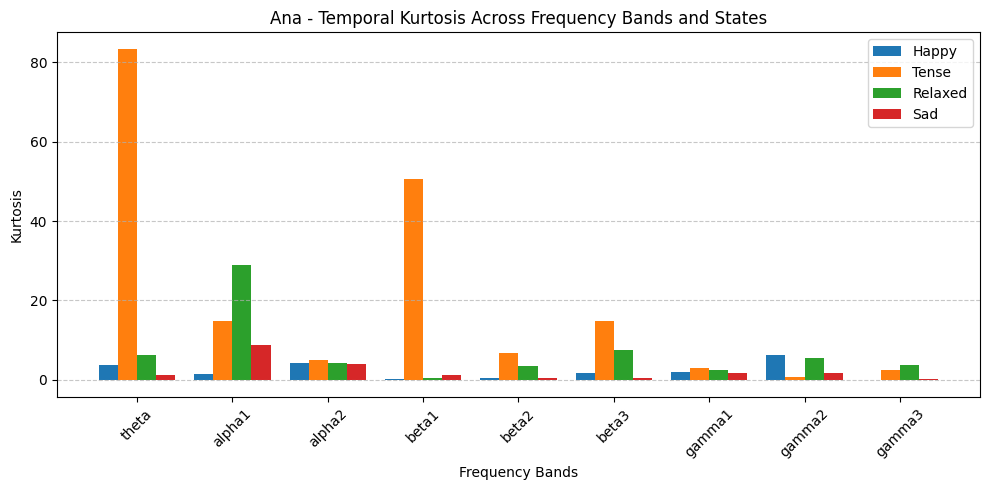

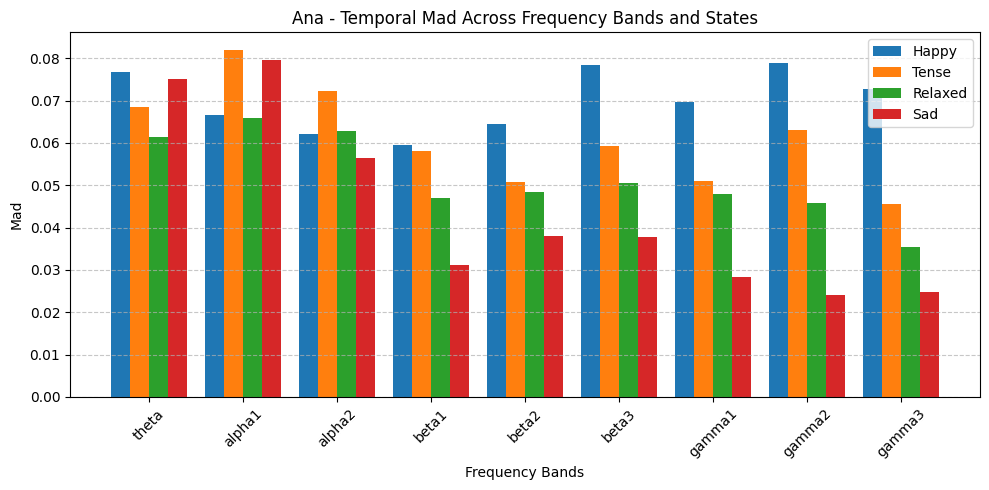

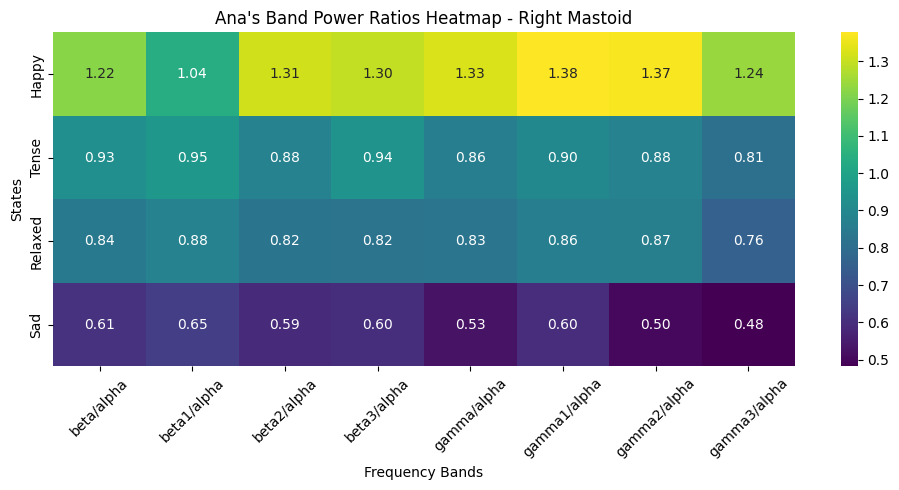

In [19]:
# # Plot Time-Domain and Frequency-Domain Data for Ana 
ana_freq_data = plot_subject_data(data=ana_data_rm, fs=fs, channels=channels, power_ylim=[100,10**7 + 1000])

# # Plot STFT Data for Ana
plot_rmastoid_stft(ana_data_rm,name='Ana',nperseg=int(fs),vmax=0.4)

# # Plot avg band power metrics for Ana data
ana_avg_band_power = calc_avg_band_power(ana_data_rm,nperseg=int(fs))
plot_avg_power(ana_avg_band_power,name='Ana')
plot_avg_power_heatmap(ana_avg_band_power,name='Ana')
plot_arousal_valence(ana_avg_band_power,name='Ana')

# # Temporal Variability Metrics for Ana
ana_temporal_metrics = calc_temporal_metrics(ana_data_rm,nperseg=int(fs),fs=fs)
plot_temporal_metrics(ana_temporal_metrics,name='Ana')

# # Obtain band power ratios for Ana and plot on Heatmap
ana_band_power_ratios = calc_band_power_ratios(ana_avg_band_power)
plot_band_ratio_heatmap(ana_band_power_ratios,name='Ana')

# Plot John Data

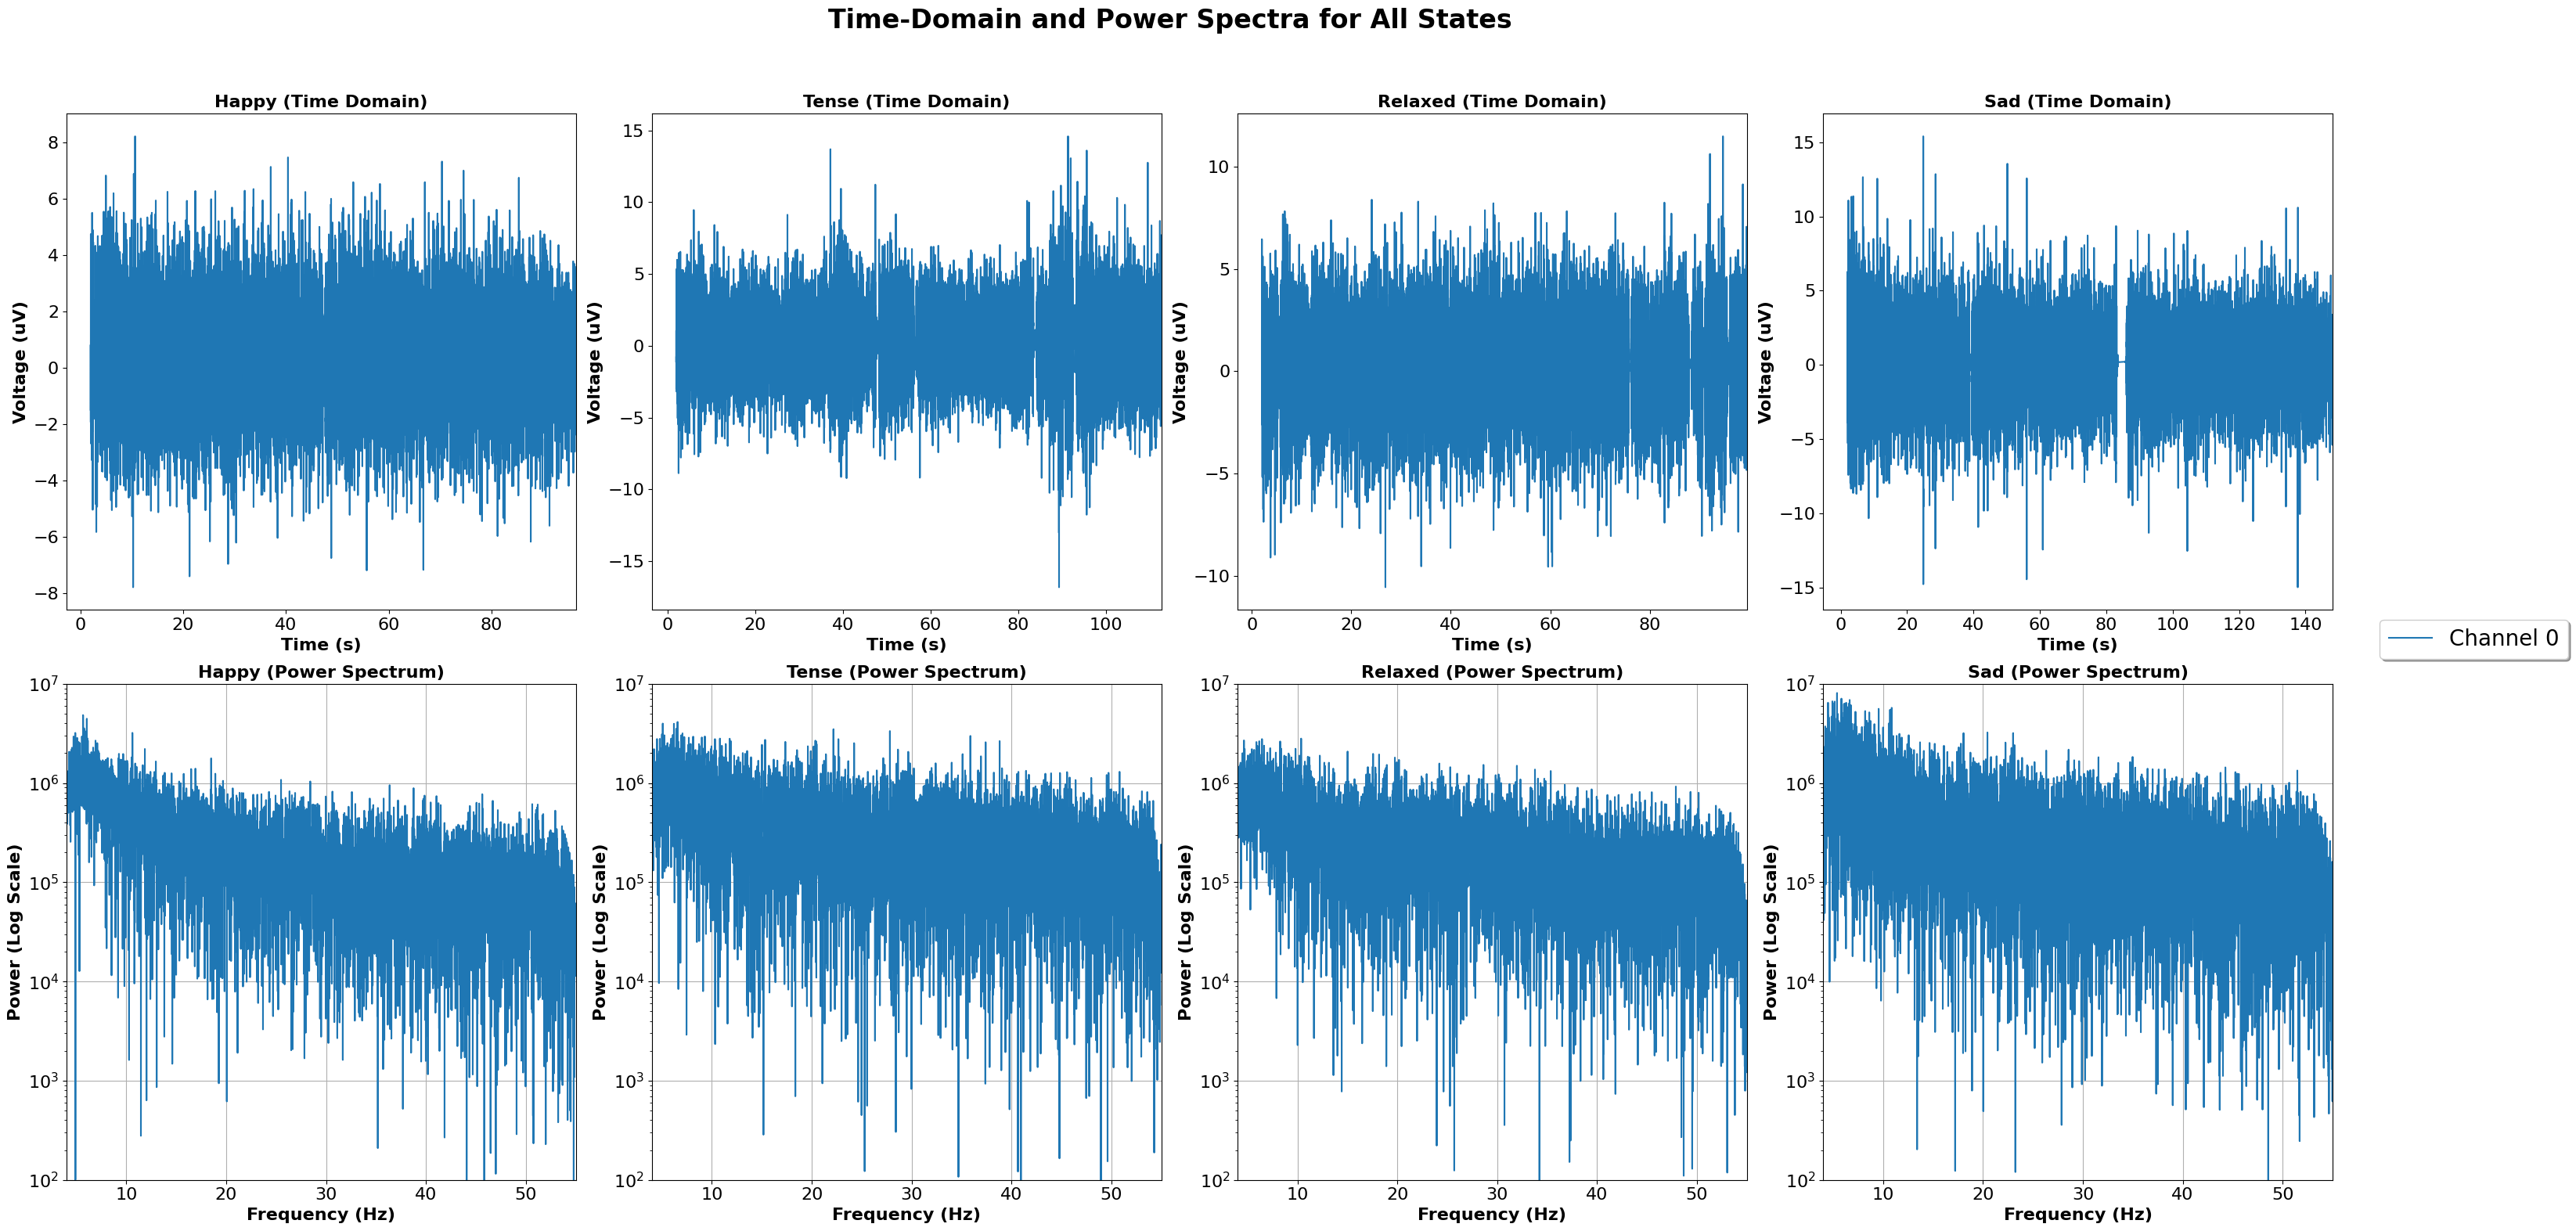

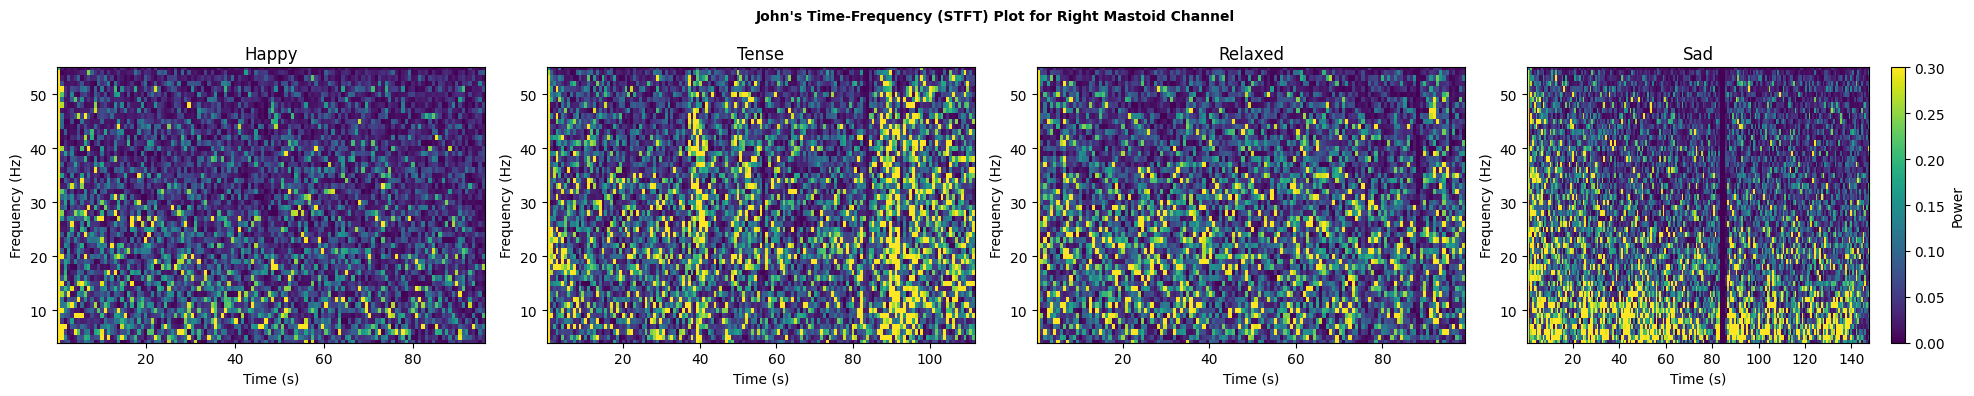

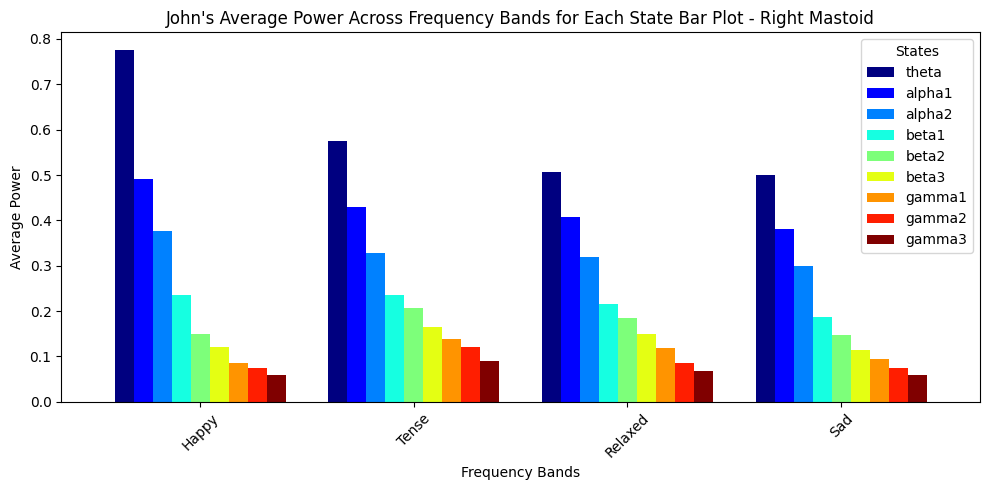

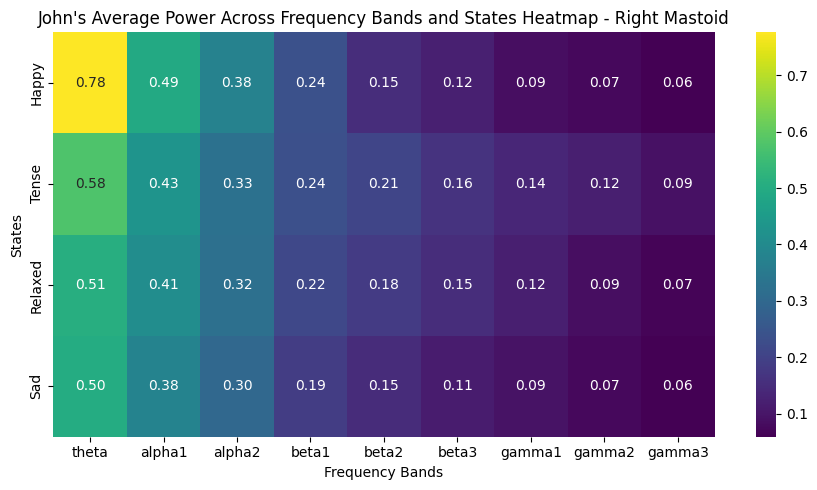

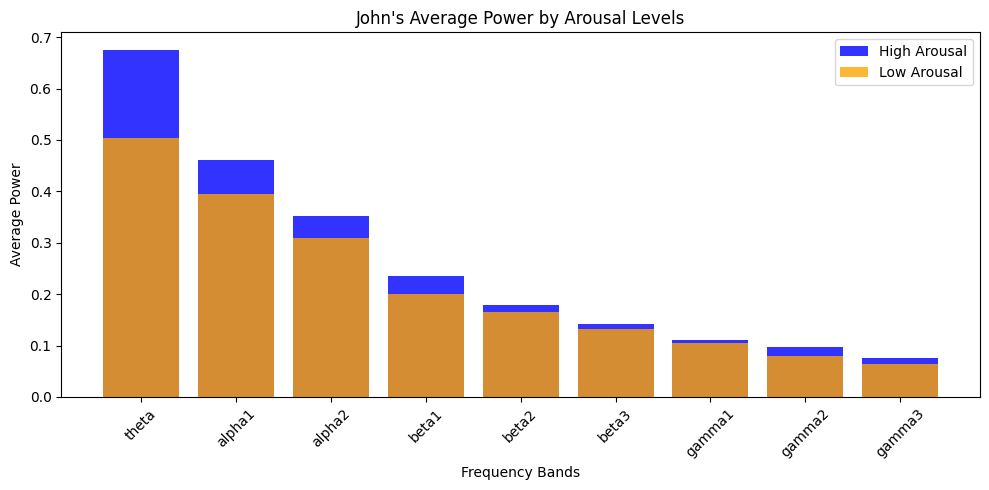

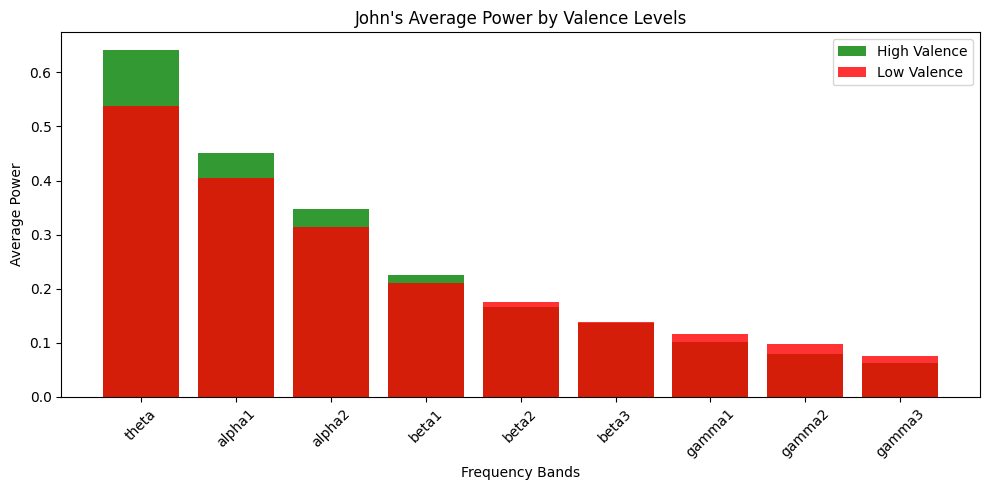

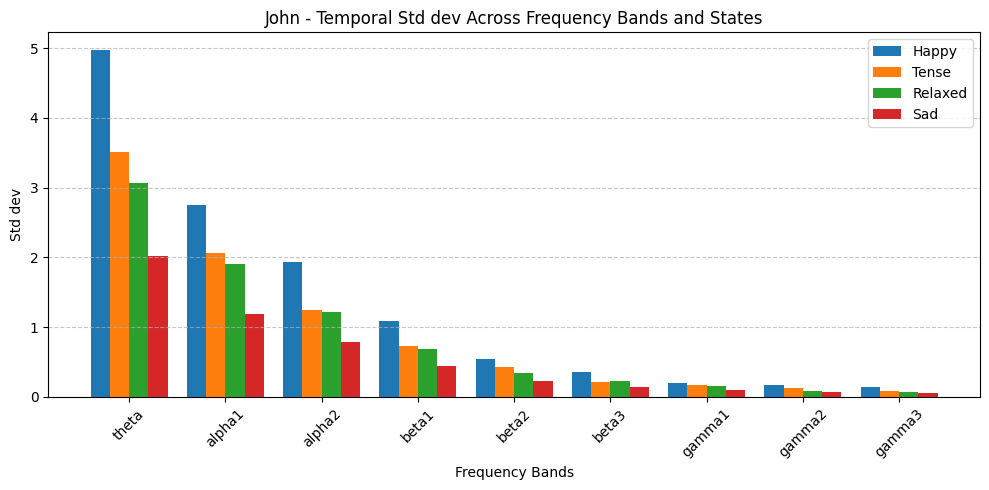

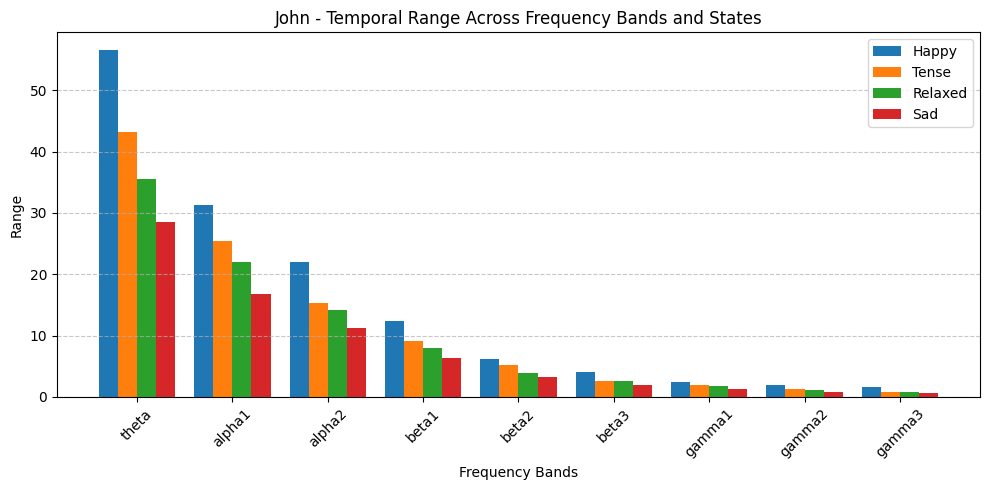

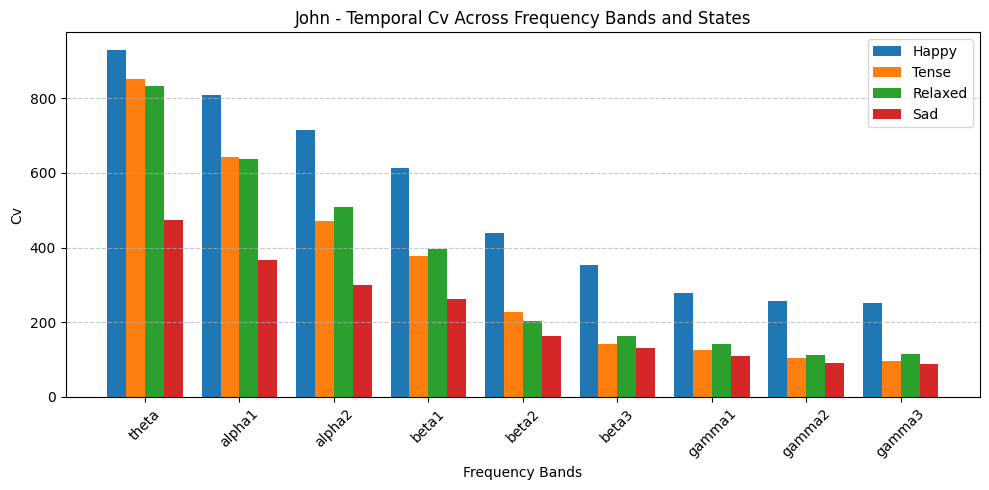

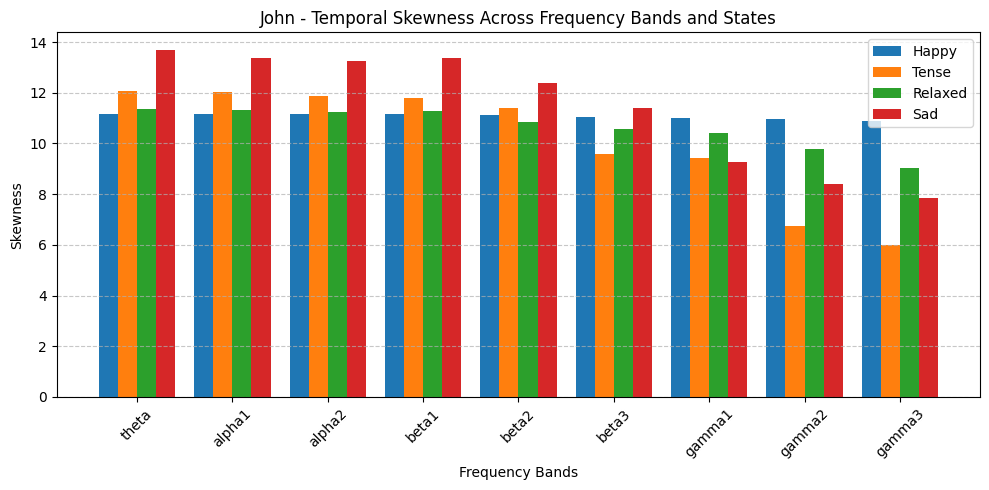

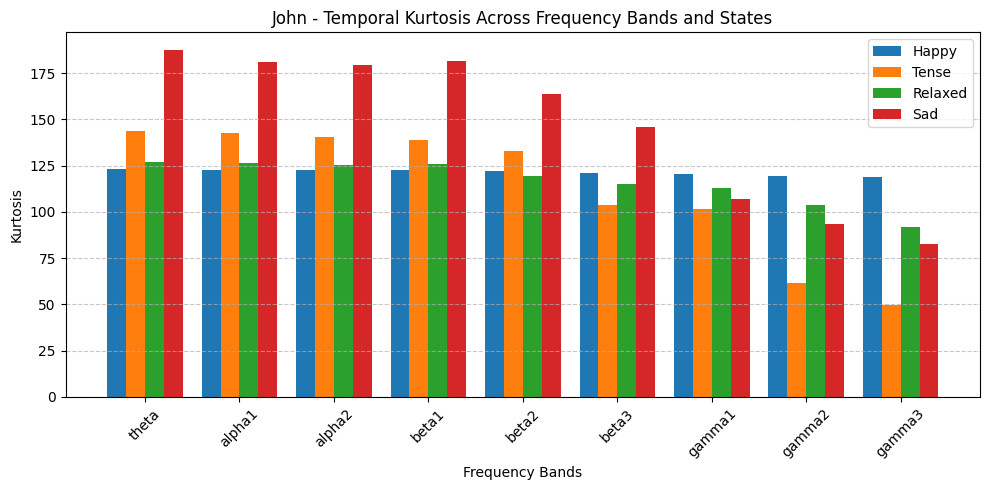

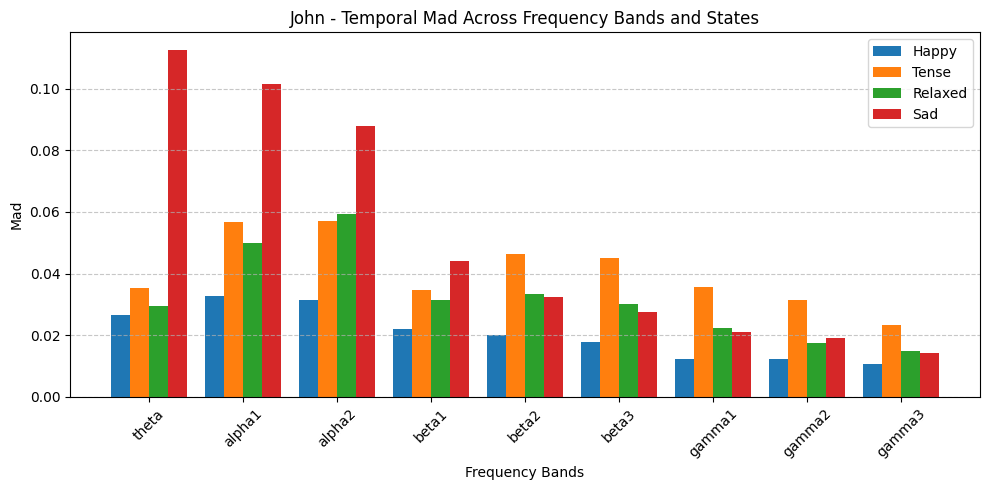

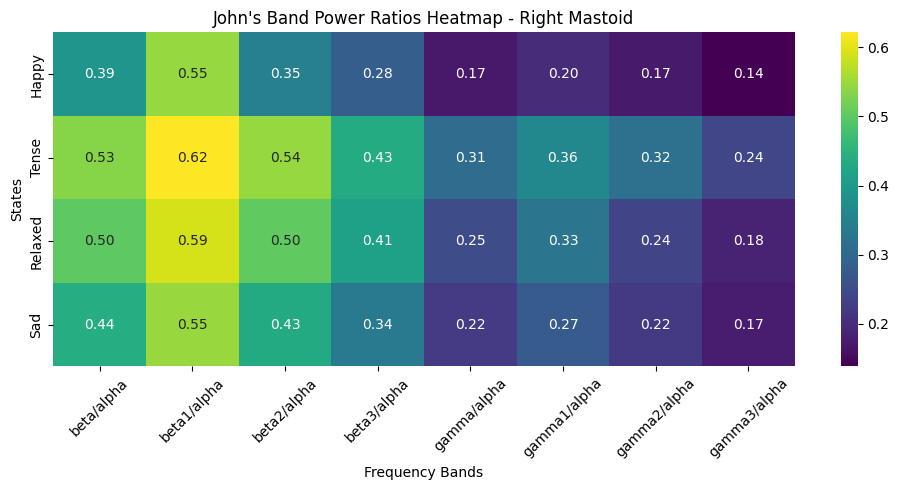

In [20]:
# # Plot Time-Domain and Frequency-Domain Data for John 
john_freq_data = plot_subject_data(data=john_data_rm, fs=fs, channels=channels, power_ylim=[100,10**7 + 1000])

# # Plot STFT Data for John
plot_rmastoid_stft(john_data_rm,name='John',nperseg=int(fs),vmax=0.3)

# # Plot avg band power metrics for John data
john_avg_band_power = calc_avg_band_power(john_data_rm,nperseg=int(fs))
plot_avg_power(john_avg_band_power,name='John')
plot_avg_power_heatmap(john_avg_band_power,name='John')
plot_arousal_valence(john_avg_band_power,name='John')

# # Temporal Variability Metrics for John
john_temporal_metrics = calc_temporal_metrics(john_data_rm,nperseg=int(fs),fs=fs)
plot_temporal_metrics(john_temporal_metrics,name='John')

# # Obtain band power ratios for John and plot on Heatmap
john_band_power_ratios = calc_band_power_ratios(john_avg_band_power)
plot_band_ratio_heatmap(john_band_power_ratios,name='John')

# Plot Jenny Data

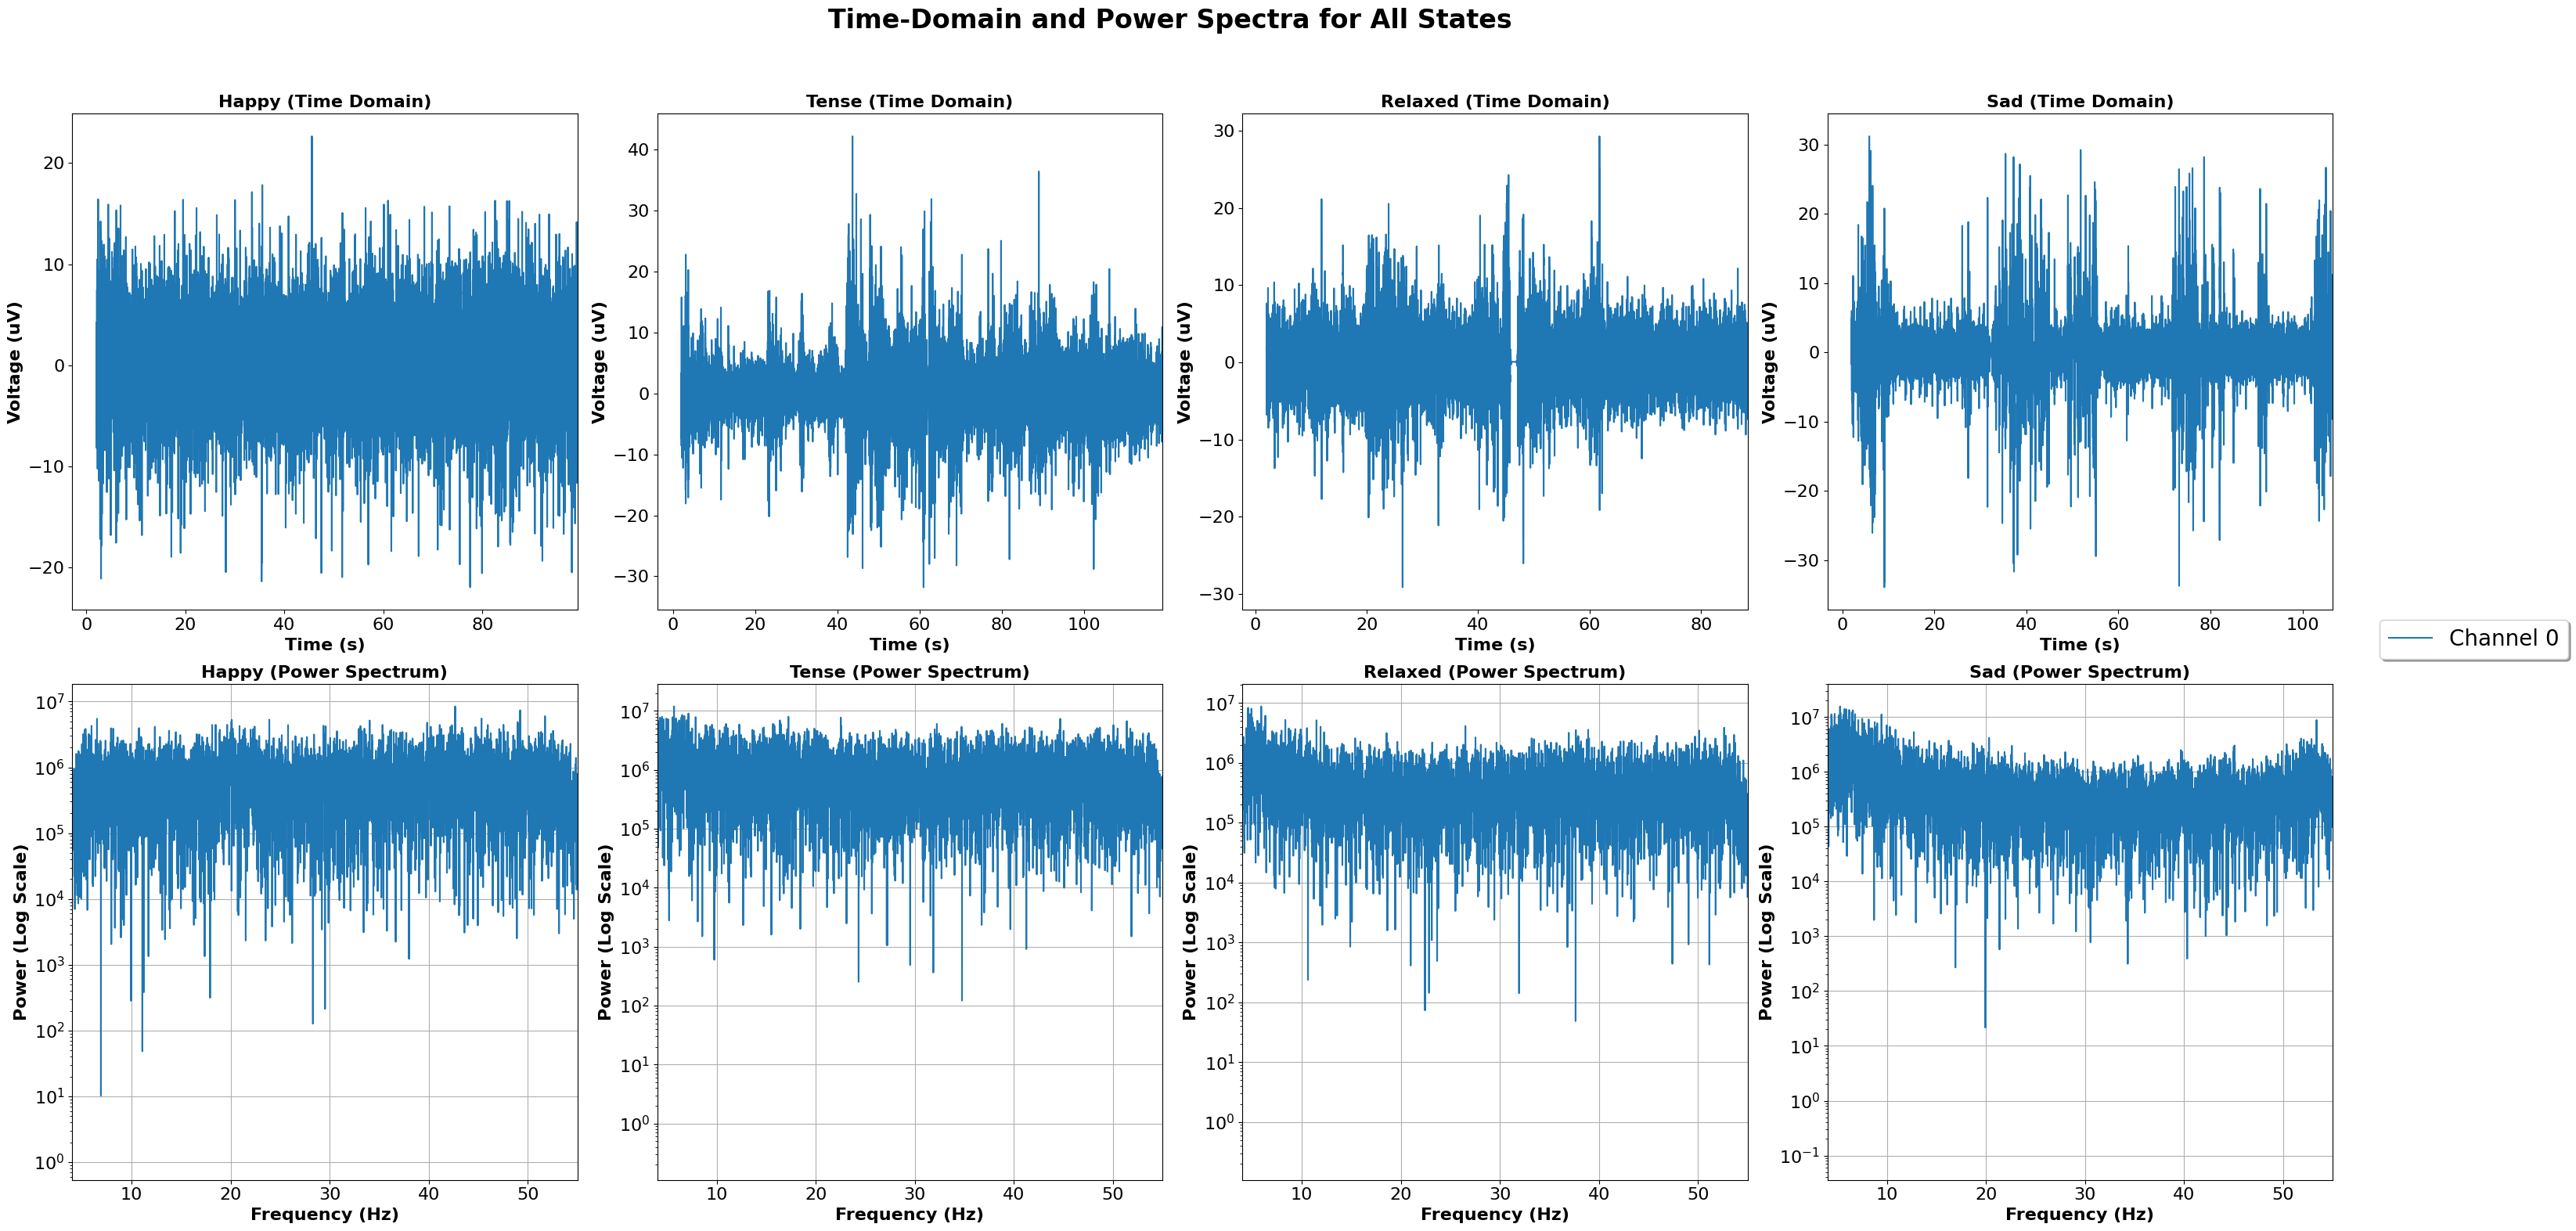

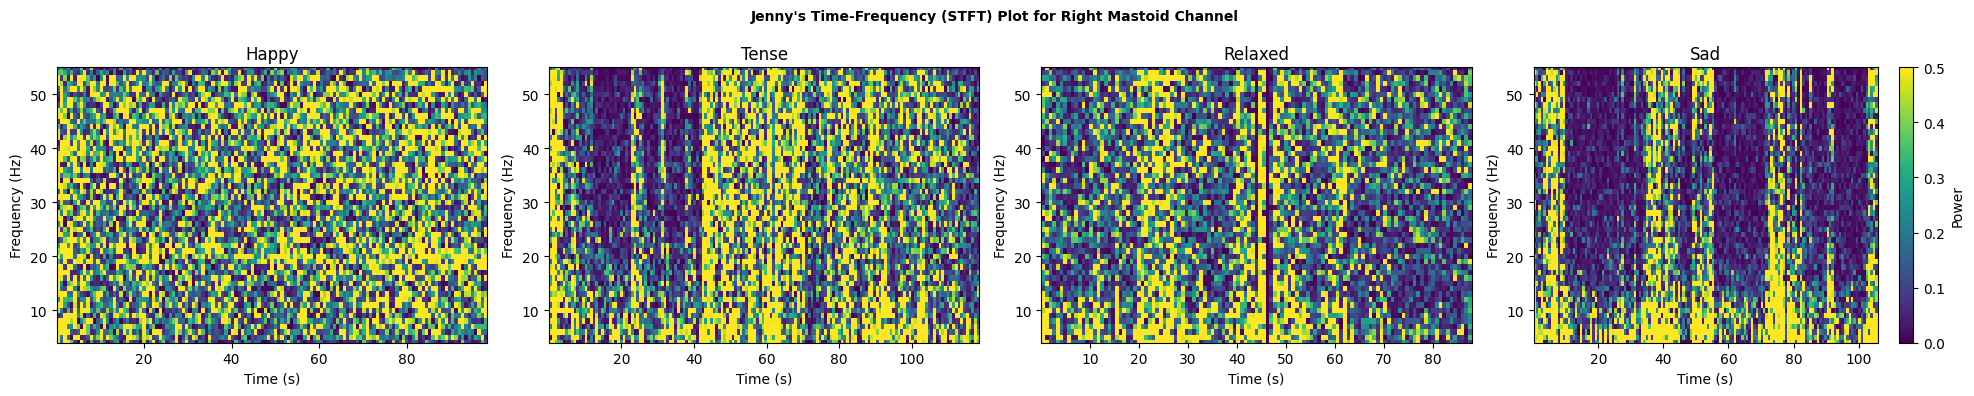

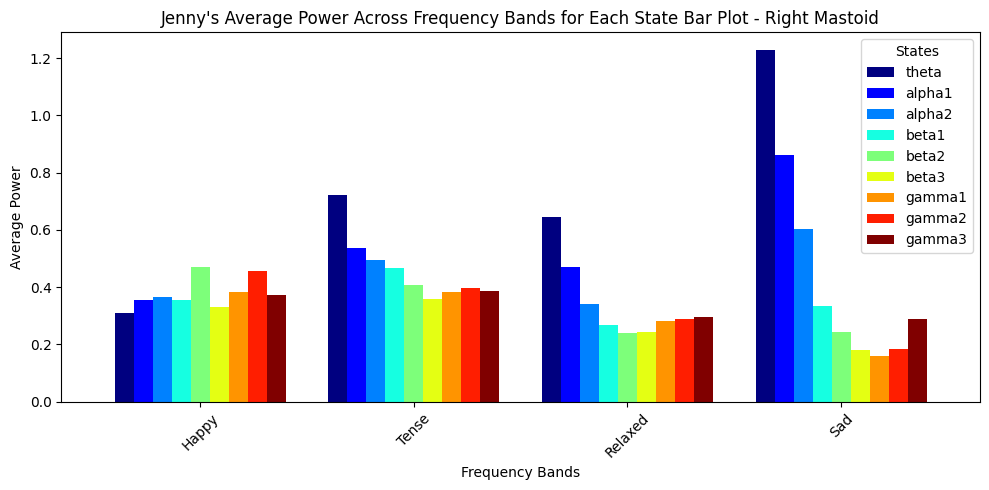

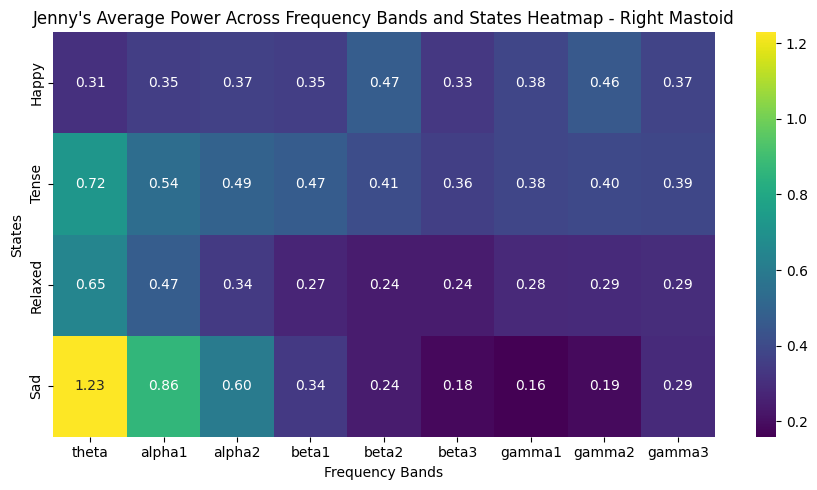

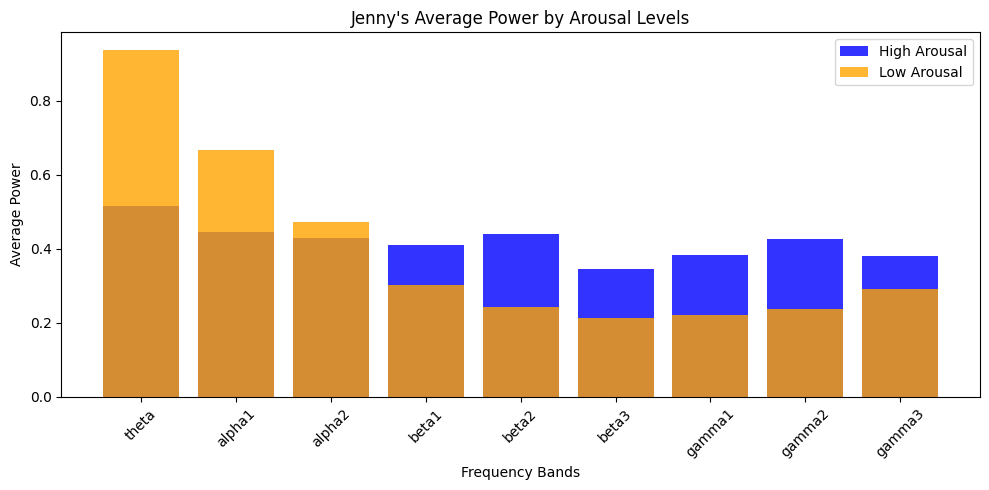

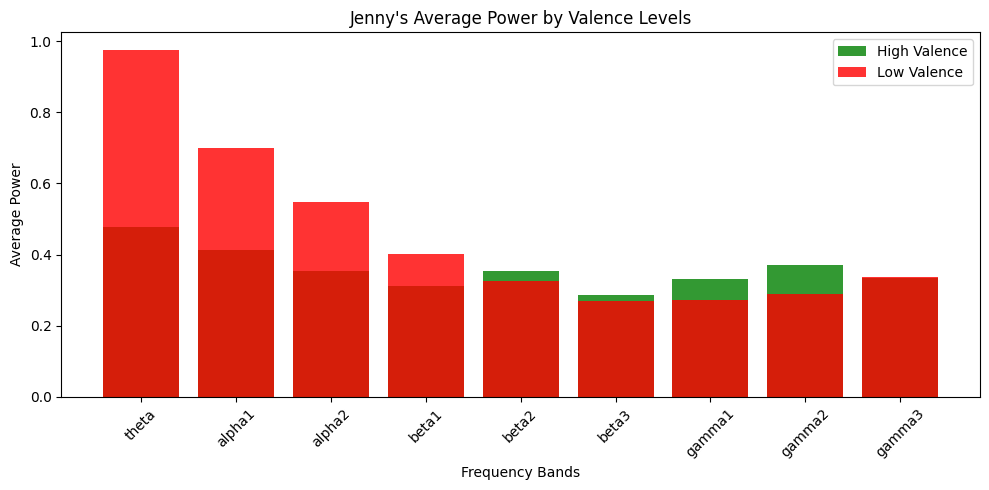

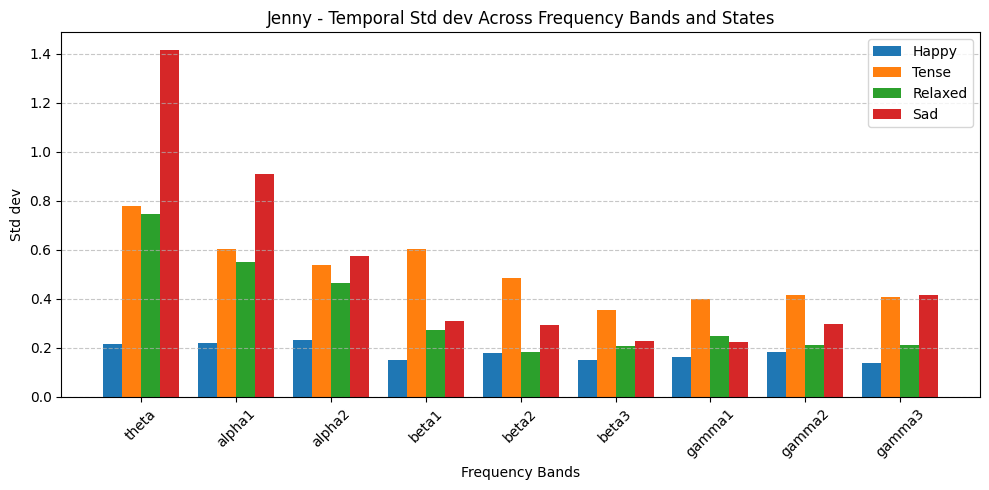

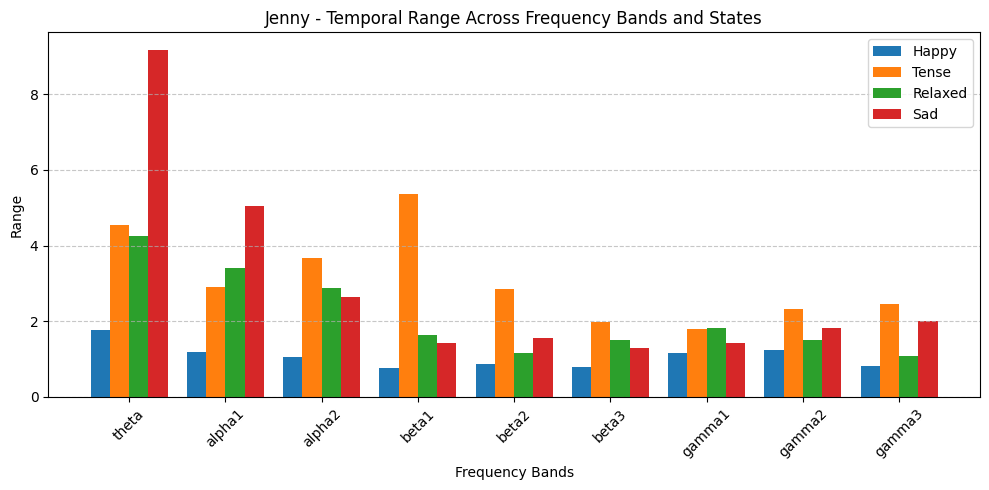

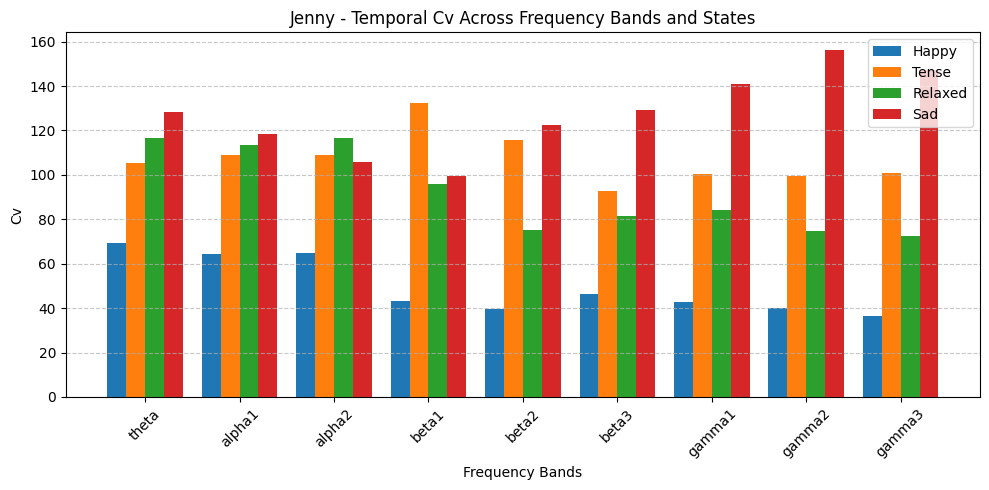

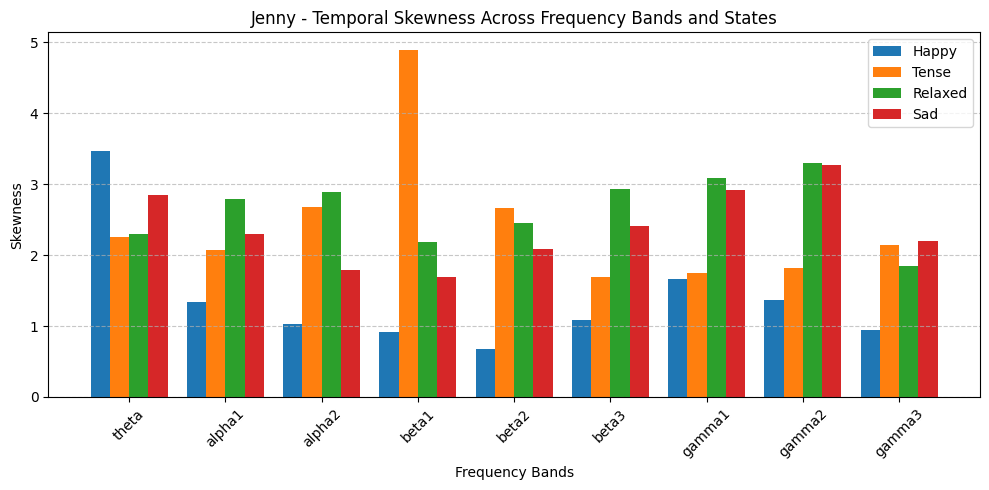

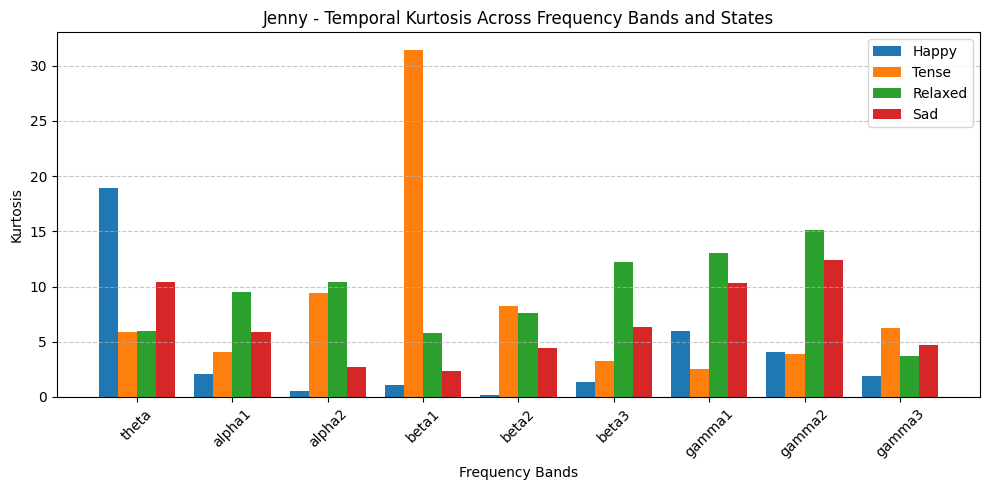

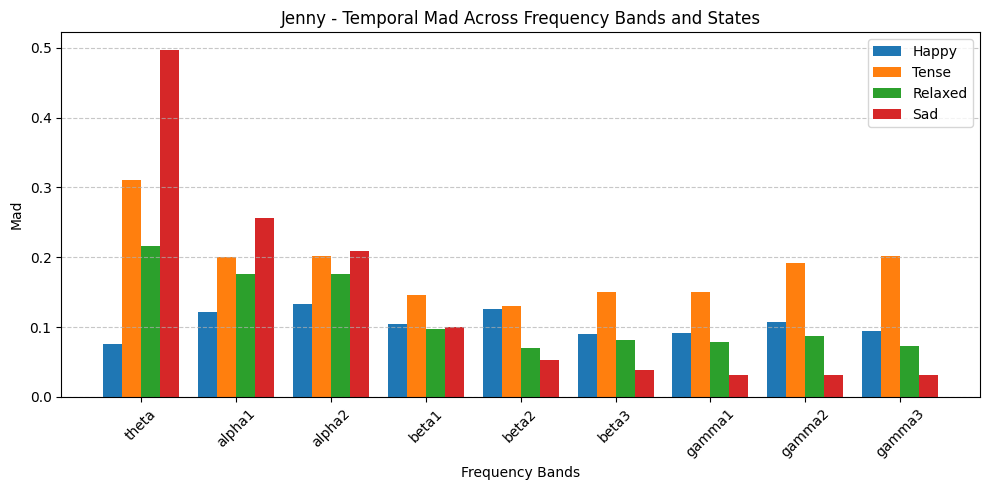

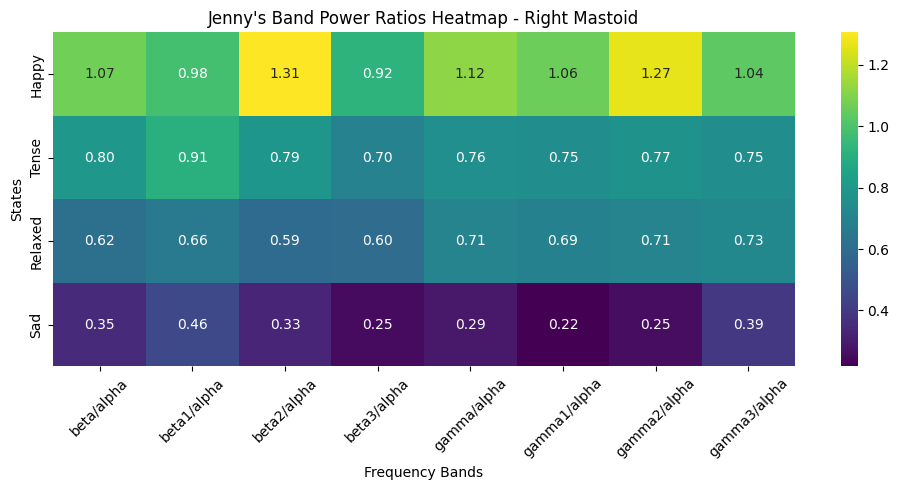

In [21]:
# # Plot Time-Domain and Frequency-Domain Data for Jenny 
jenny_freq_data = plot_subject_data(data=jenny_data_rm, fs=fs, channels=channels)#, power_ylim=[100,10**9 + 1000])

# # Plot STFT Data for Jenny
plot_rmastoid_stft(jenny_data_rm,name='Jenny',nperseg=int(fs),vmax=0.5)

# # Plot avg band power metrics for Jenny data
jenny_avg_band_power = calc_avg_band_power(jenny_data_rm,nperseg=int(fs))
plot_avg_power(jenny_avg_band_power,name='Jenny')
plot_avg_power_heatmap(jenny_avg_band_power,name='Jenny')
plot_arousal_valence(jenny_avg_band_power,name='Jenny')

# # Temporal Variability Metrics for Jenny
jenny_temporal_metrics = calc_temporal_metrics(jenny_data_rm,nperseg=int(fs),fs=fs)
plot_temporal_metrics(jenny_temporal_metrics,name='Jenny')

# # Obtain band power ratios for Jenny and plot on Heatmap
jenny_band_power_ratios = calc_band_power_ratios(jenny_avg_band_power)
plot_band_ratio_heatmap(jenny_band_power_ratios,name='Jenny')

# Plot Ale Data

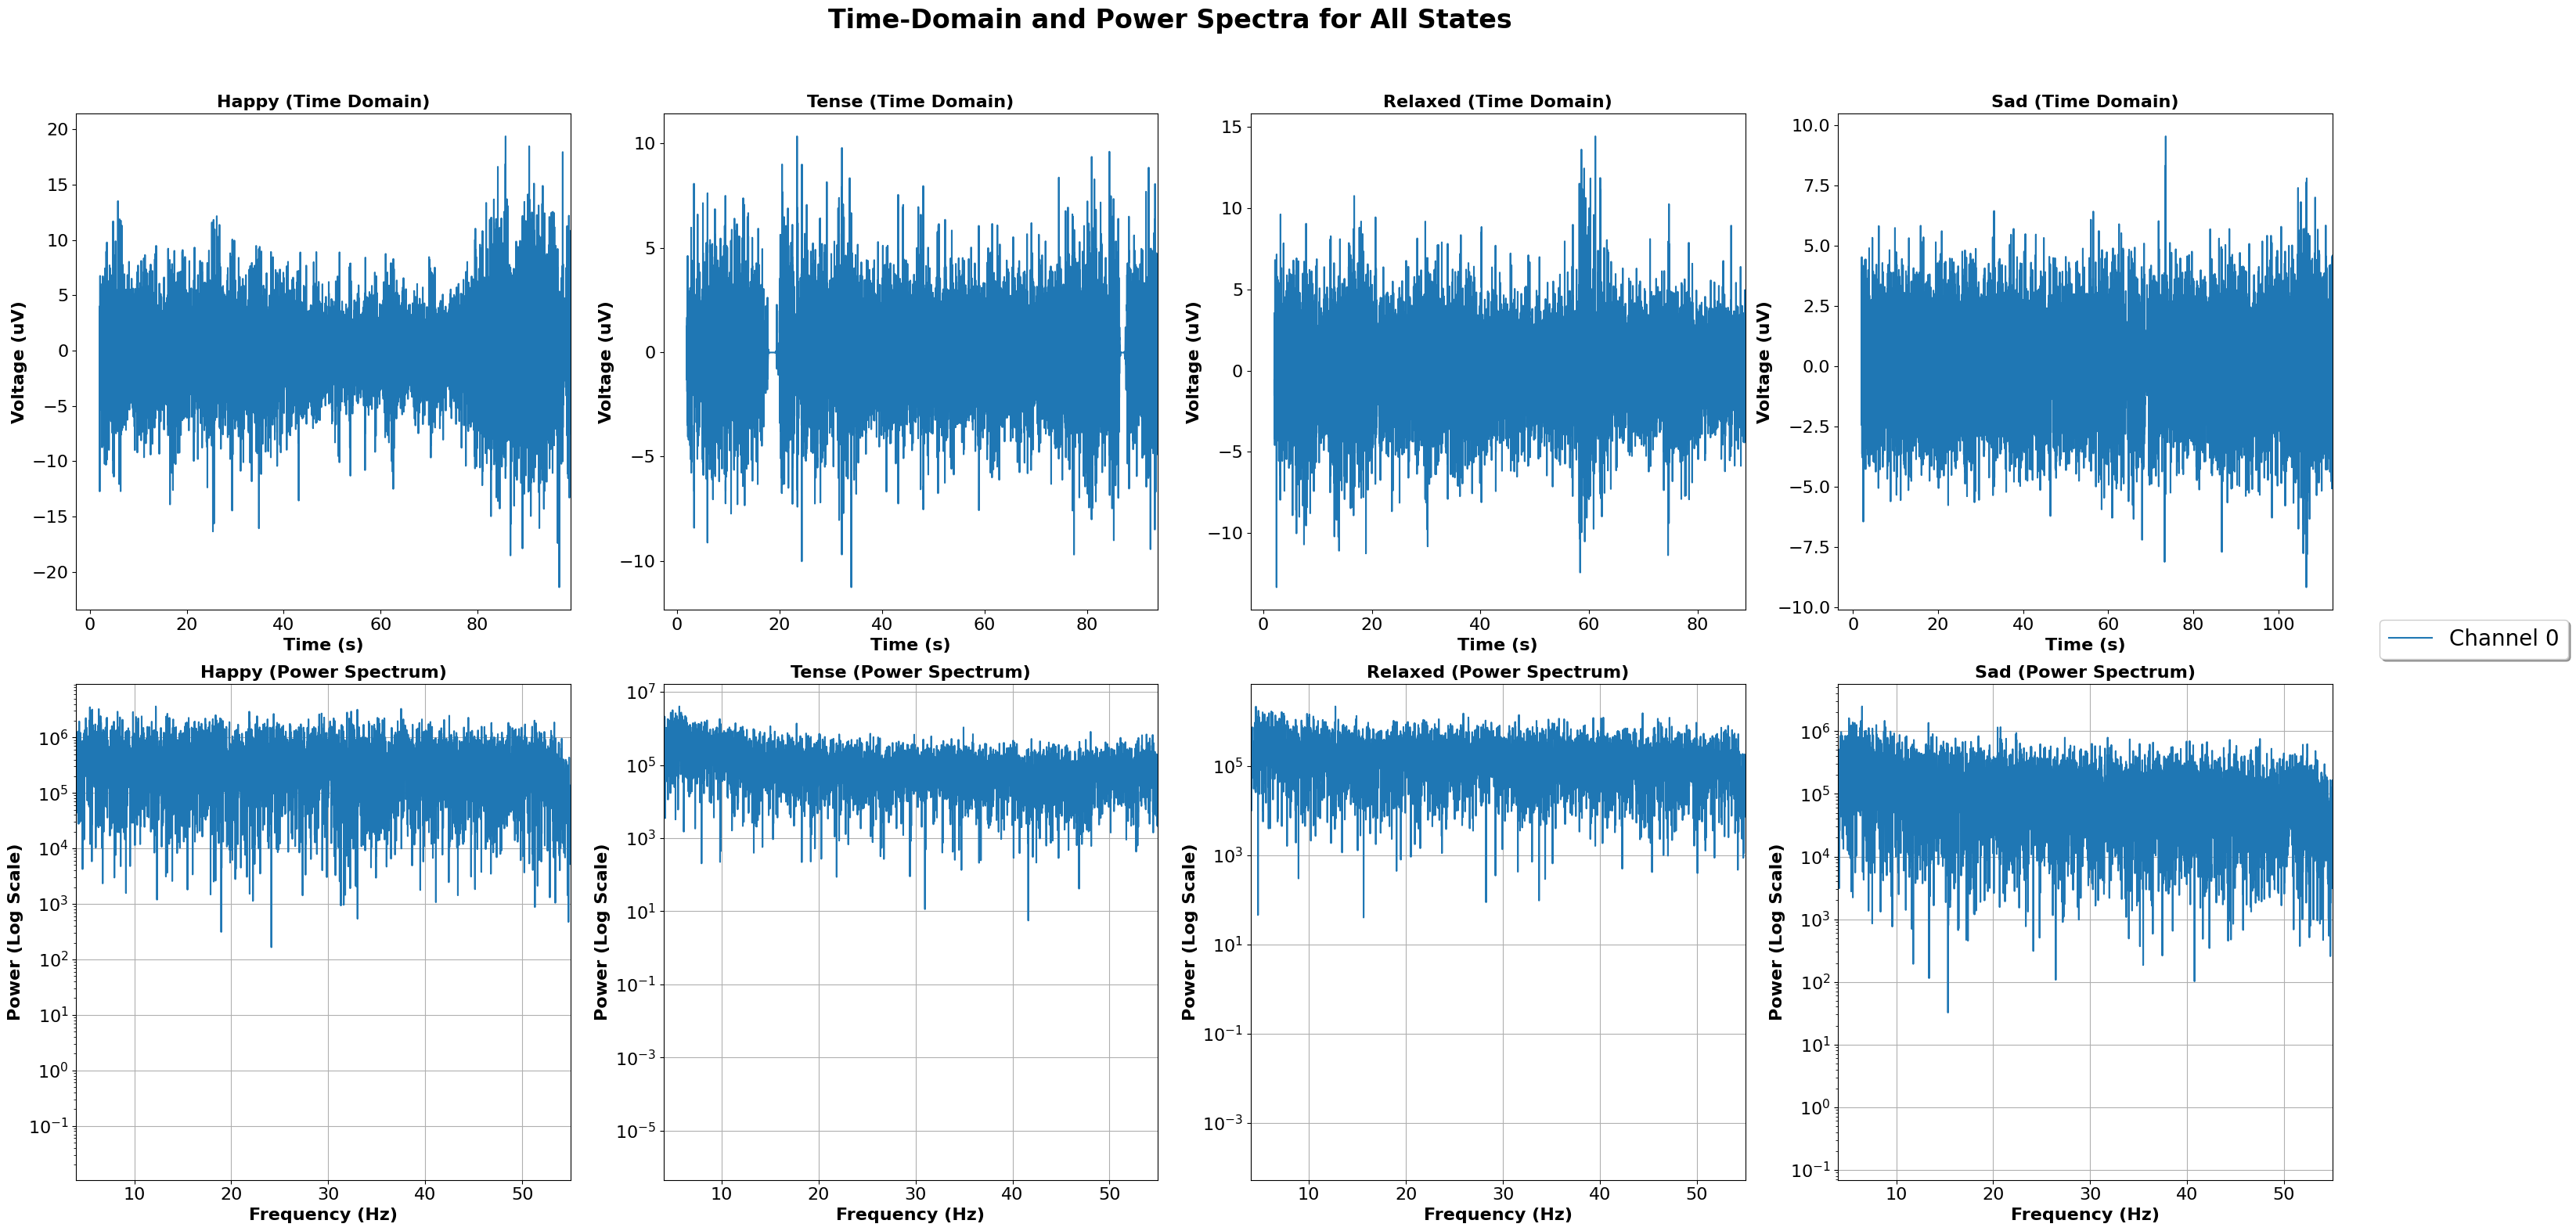

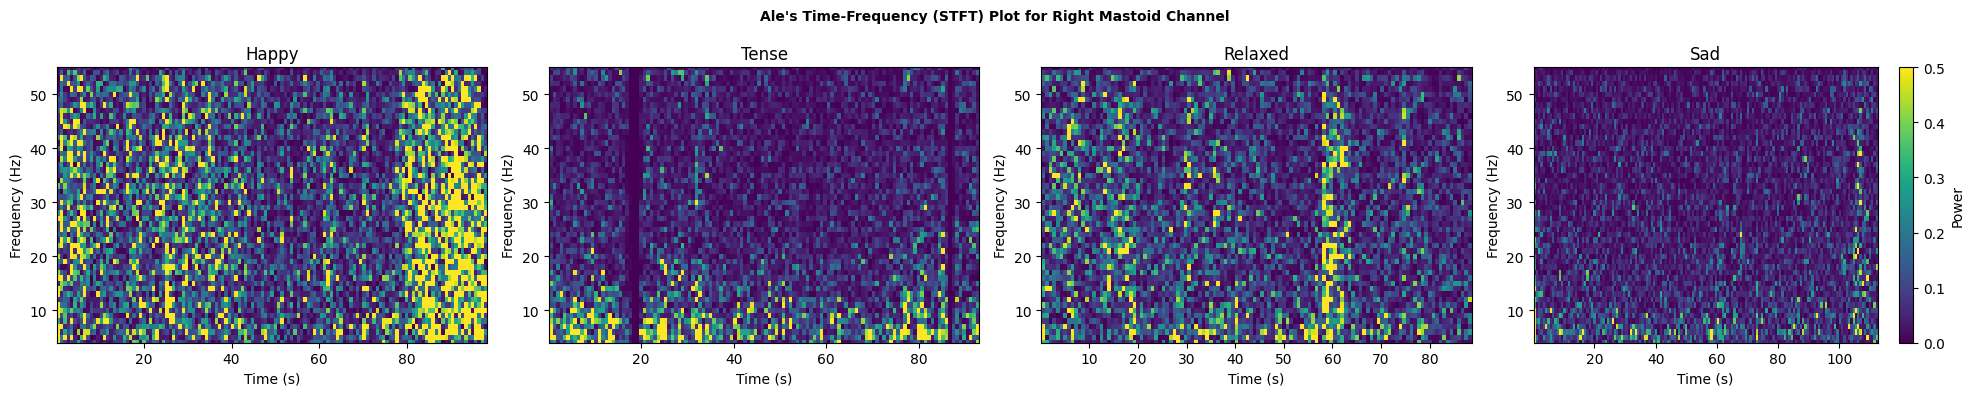

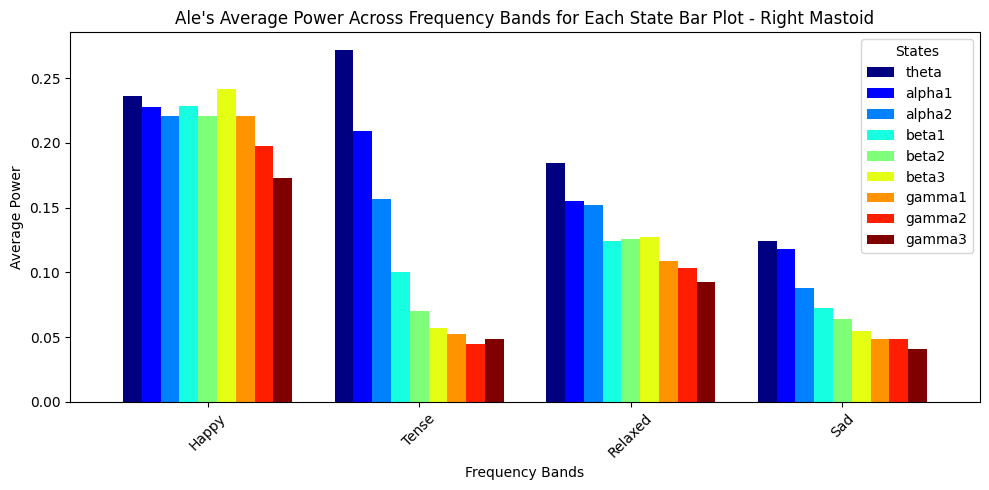

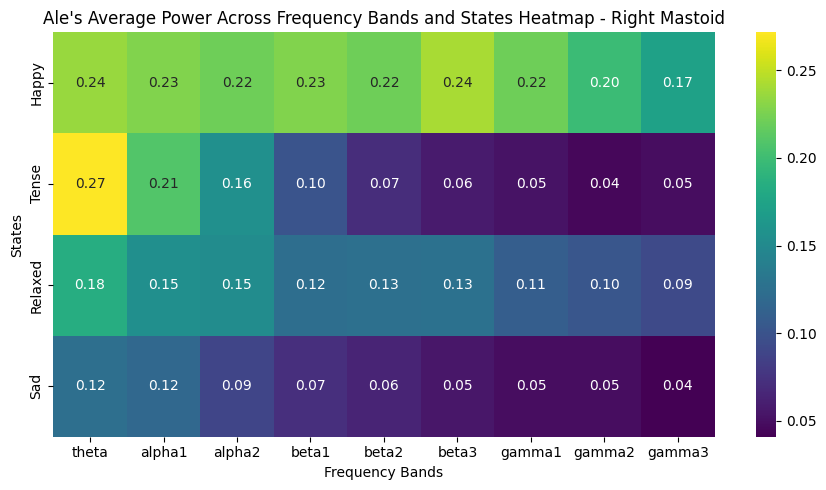

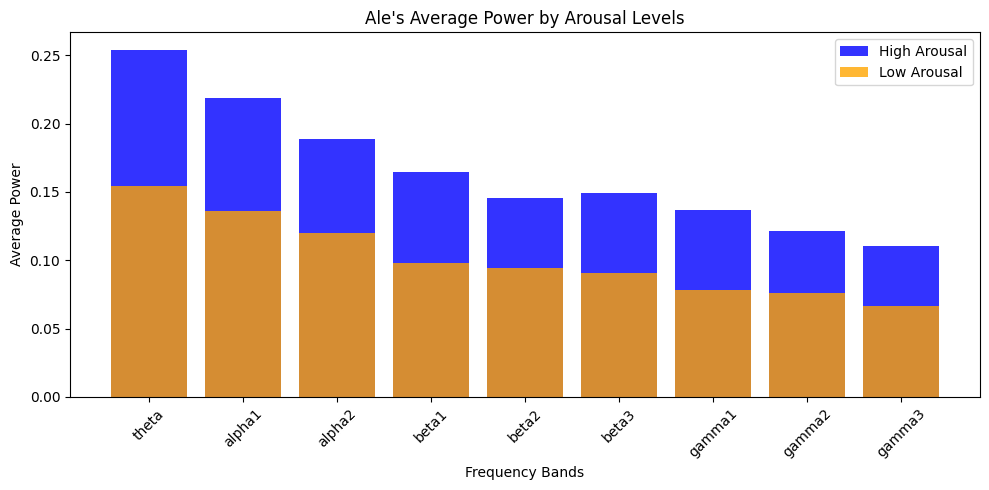

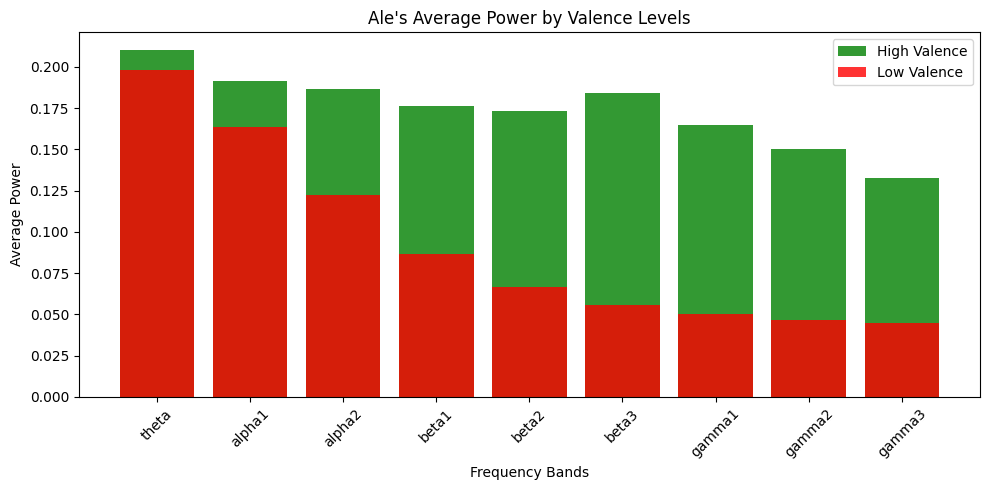

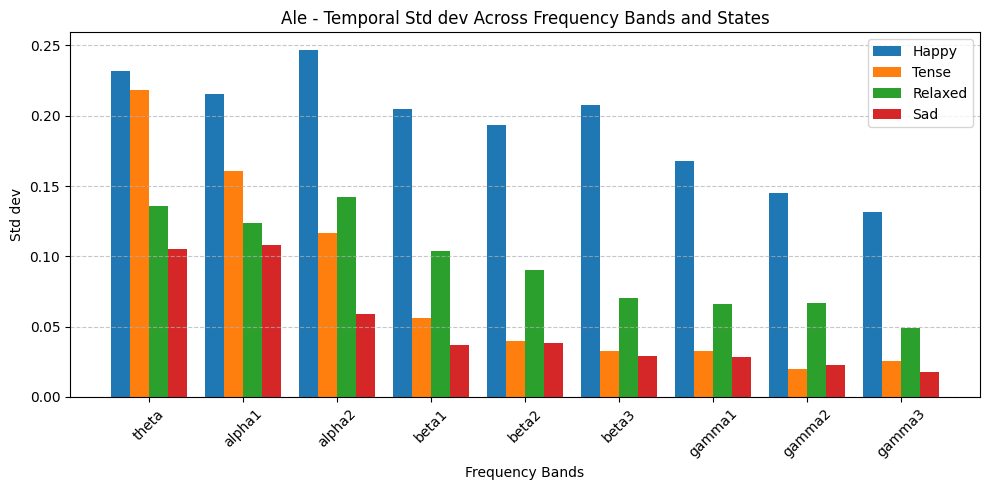

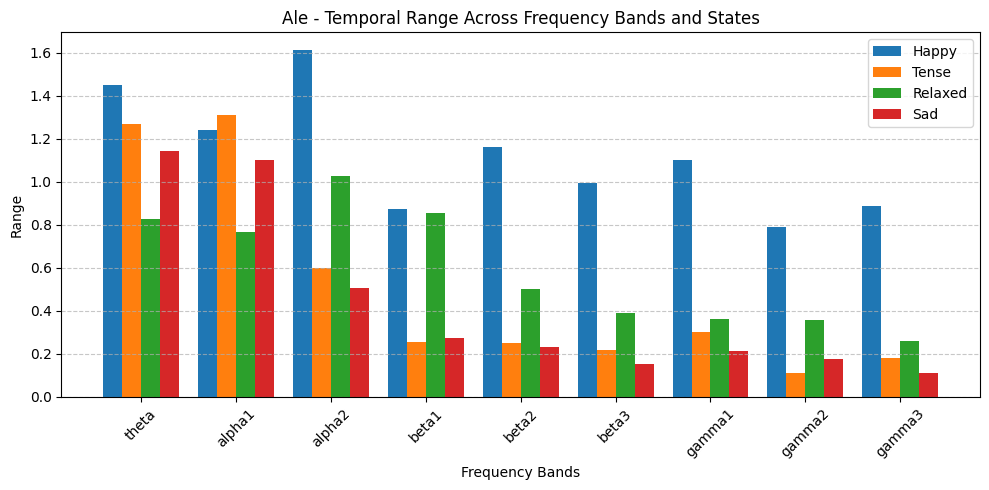

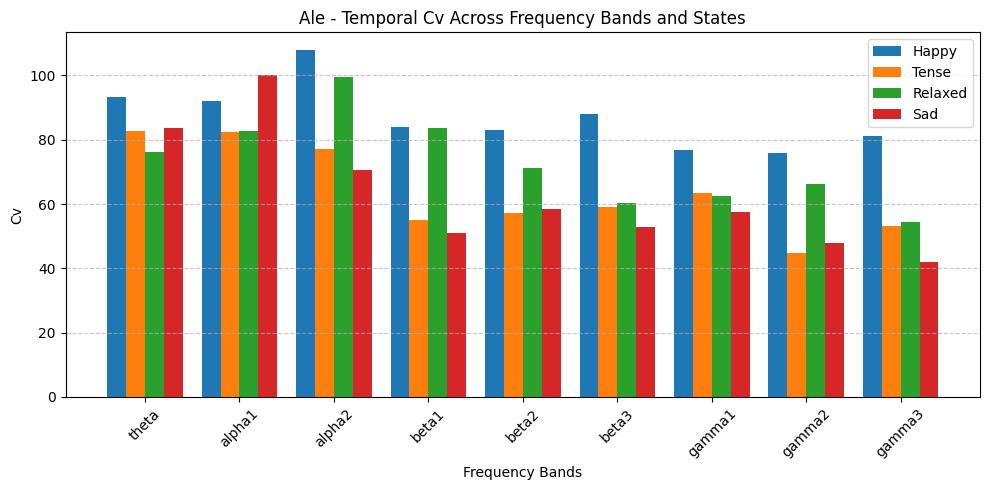

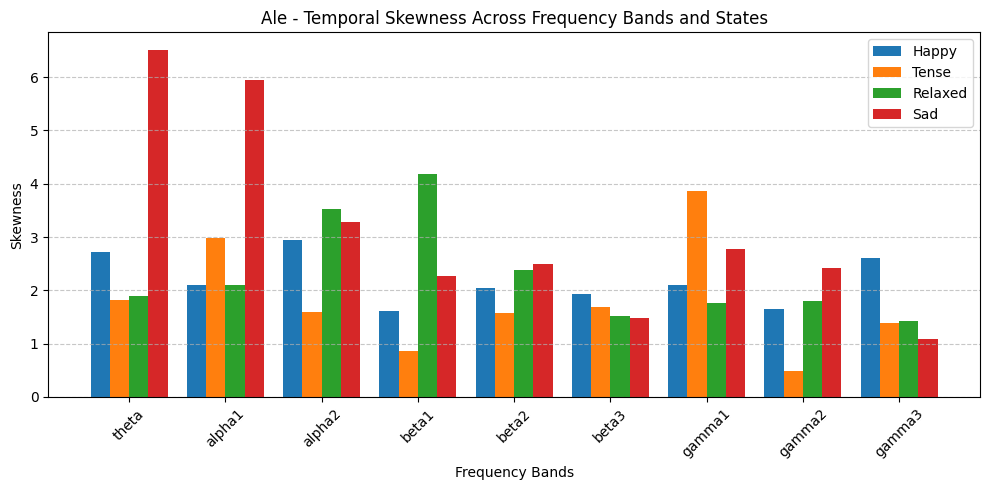

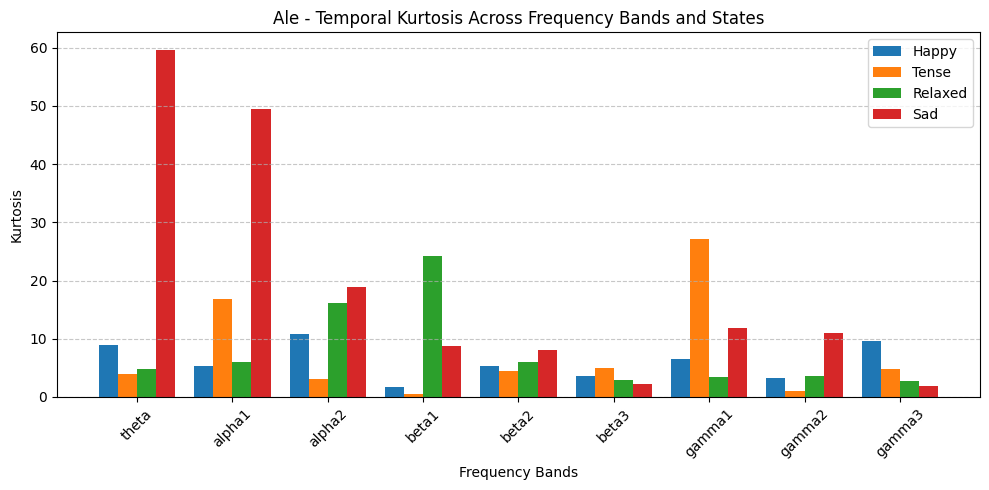

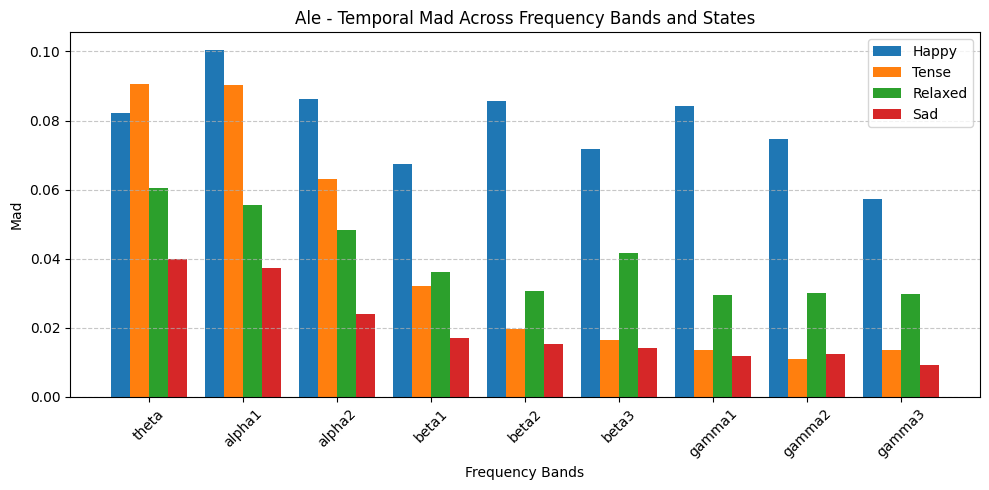

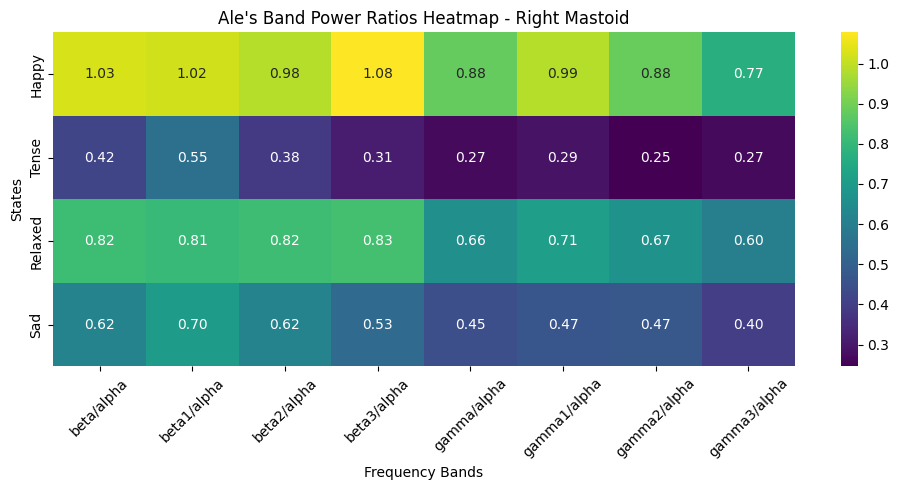

In [22]:
# # Plot Time-Domain and Frequency-Domain Data for Ale 
ale_freq_data = plot_subject_data(data=ale_data_rm, fs=fs, channels=channels)#, power_ylim=[100,10**9 + 1000])

# # Plot STFT Data for Ale
plot_rmastoid_stft(ale_data_rm,name='Ale',nperseg=int(fs),vmax=0.5)

# # Plot avg band power metrics for Ale data
ale_avg_band_power = calc_avg_band_power(ale_data_rm,nperseg=int(fs))
plot_avg_power(ale_avg_band_power,name='Ale')
plot_avg_power_heatmap(ale_avg_band_power,name='Ale')
plot_arousal_valence(ale_avg_band_power,name='Ale')

# # Temporal Variability Metrics for Ale
ale_temporal_metrics = calc_temporal_metrics(ale_data_rm,nperseg=int(fs),fs=fs)
plot_temporal_metrics(ale_temporal_metrics,name='Ale')

# # Obtain band power ratios for Ale and plot on Heatmap
ale_band_power_ratios = calc_band_power_ratios(ale_avg_band_power)
plot_band_ratio_heatmap(ale_band_power_ratios,name='Ale')

# Plot Only Band Power Ratios Heatmap for All Participants

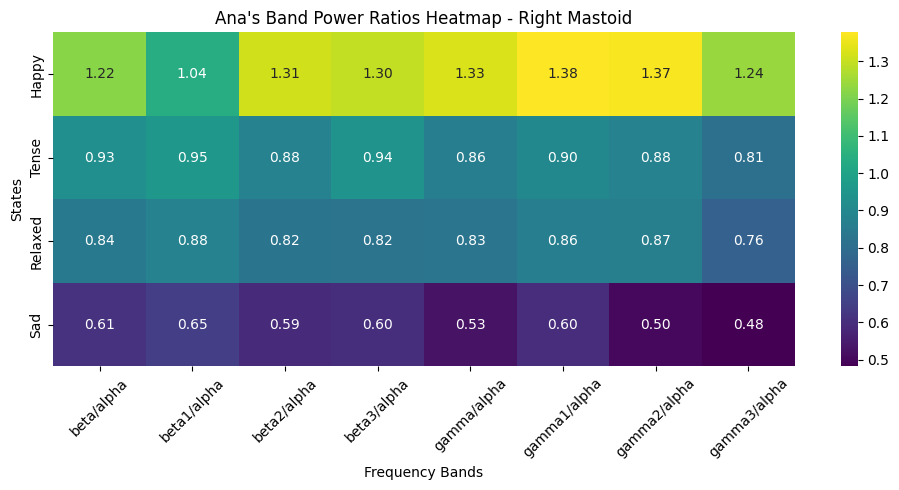

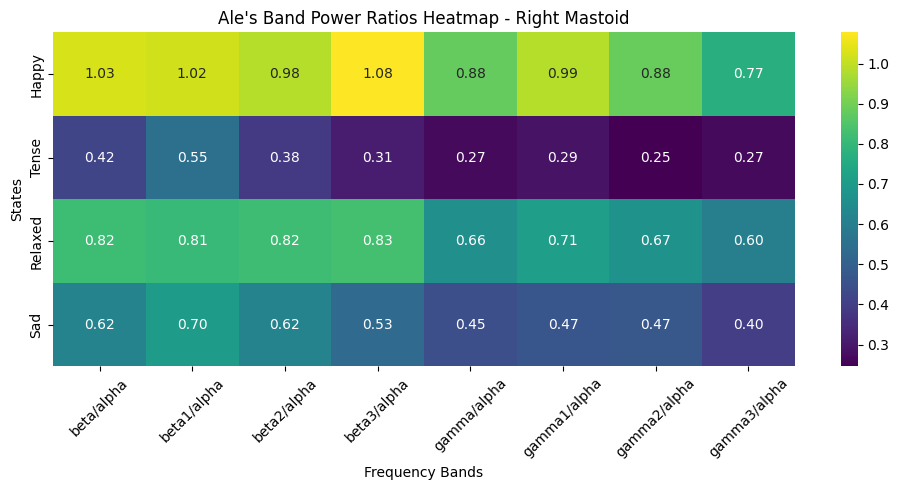

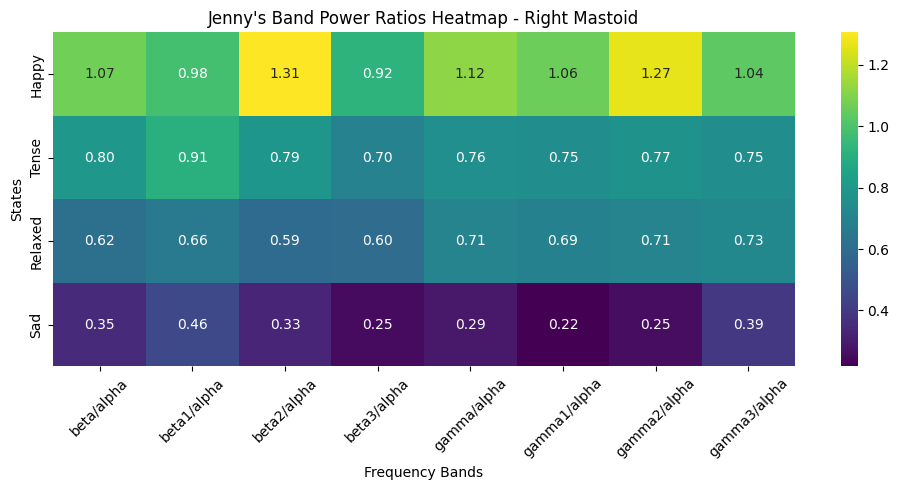

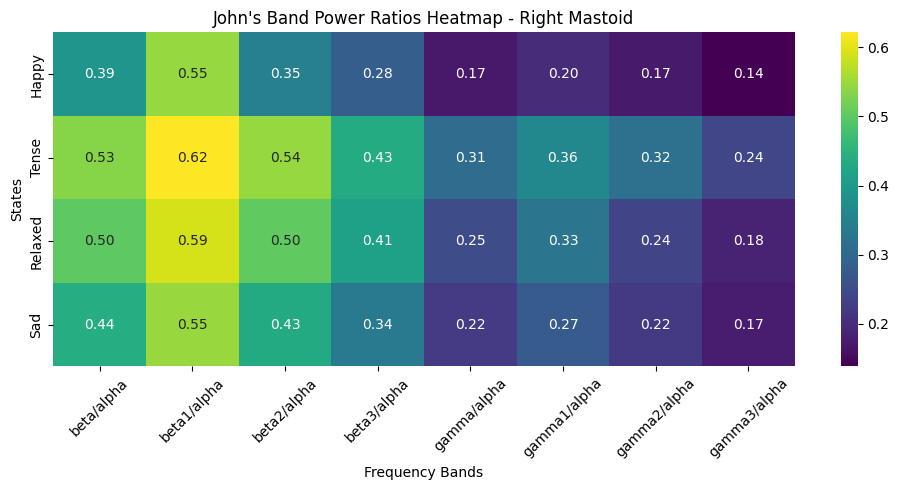

In [23]:
plot_band_ratio_heatmap(ana_band_power_ratios,name='Ana')
plot_band_ratio_heatmap(ale_band_power_ratios,name='Ale')
plot_band_ratio_heatmap(jenny_band_power_ratios,name='Jenny')
plot_band_ratio_heatmap(john_band_power_ratios,name='John')

In [26]:
print(ana_band_power_ratios["Happy"].keys())

dict_keys(['beta/alpha', 'beta1/alpha', 'beta2/alpha', 'beta3/alpha', 'gamma/alpha', 'gamma1/alpha', 'gamma2/alpha', 'gamma3/alpha'])


In [24]:
# # Create table comparing ratios across participants 

antonio_happy_gamma = [0.87, 0.90, 0.88, 0.84]
antonio_sad_gamma = [0.30,0.33, 0.33, 0.25]

ana_happy_gamma = [ana_band_power_ratios['Happy'][key] for key in list(ana_band_power_ratios['Happy'].keys())[4:]]
ana_sad_gamma = [ana_band_power_ratios['Sad'][key] for key in list(ana_band_power_ratios['Sad'].keys())[4:]]

jenny_happy_gamma = [jenny_band_power_ratios['Happy'][key] for key in list(jenny_band_power_ratios['Happy'].keys())[4:]]
jenny_sad_gamma = [jenny_band_power_ratios['Sad'][key] for key in list(jenny_band_power_ratios['Sad'].keys())[4:]]

ale_happy_gamma = [ale_band_power_ratios['Happy'][key] for key in list(ale_band_power_ratios['Happy'].keys())[4:]]
ale_sad_gamma = [ale_band_power_ratios['Sad'][key] for key in list(ale_band_power_ratios['Sad'].keys())[4:]]

luisa_happy_gamma = [0.31, 0.34, 0.35, 0.23]
luisa_sad_gamma = [3.56, 3.75, 4.20, 2.73]

john_happy_gamma = [john_band_power_ratios['Happy'][key] for key in list(john_band_power_ratios['Happy'].keys())[4:]]
john_sad_gamma = [john_band_power_ratios['Sad'][key] for key in list(john_band_power_ratios['Sad'].keys())[4:]]

happy_gamma_ratios = [antonio_happy_gamma,ana_happy_gamma,jenny_happy_gamma,ale_happy_gamma,luisa_happy_gamma,john_happy_gamma]
sad_gamma_ratios = [antonio_sad_gamma,ana_sad_gamma,jenny_sad_gamma,ale_sad_gamma,luisa_sad_gamma,john_sad_gamma]

# gamma_ratios_dict = {
#     "Participant": ["Antonio", "Ana", "Jenny", "Ale", "Luisa", "John"],
#     "(Valence, Arousal)": ['(9,8)','(9,9)','(8,7)','(9,9)','(8,8)','(8,7)'],
#     "Happy(Mean ± Std)": [f"{np.mean(participant):.2f} ± {np.std(participant):.2f}" for participant in happy_gamma_ratios],
#     "(Valence,Arousal)": ['(2,1)','(3,3)','(3,2)','(2,2)','(3,2)','(2,6)'],
#     "Sad(Mean ± Std)": [f"{np.mean(participant):.2f} ± {np.std(participant):.2f}" for participant in sad_gamma_ratios],
#     "Percent Difference ±": [f"{((np.mean(participant_happy) - np.mean(participant_sad))/np.mean(participant_sad))*100:.2f}%" 
#                    for participant_happy,participant_sad in zip(happy_gamma_ratios,sad_gamma_ratios)]
# }

happy_valence_arousal = ['(9,8)','(9,9)','(8,7)','(9,9)','(8,8)','(8,7)']
sad_valence_arousal = ['(2,1)','(3,3)','(3,2)','(2,2)','(3,2)','(2,6)']

gamma_ratios_dict = {
    "Participant": ["Antonio", "Ana", "Jenny", "Ale", "Luisa", "John"],
    "Happy(Mean ± Std)": [f"{np.mean(participant)*100:.2f} ± {np.std(participant)*100:.2f} {happy_valence_arousal[i]}" 
                          for i,participant in enumerate(happy_gamma_ratios)],
    "Sad(Mean ± Std)": [f"{np.mean(participant)*100:.2f} ± {np.std(participant)*100:.2f} {sad_valence_arousal[i]}" 
                        for i,participant in enumerate(sad_gamma_ratios)],
    "Percent Difference ±": [f"{((np.mean(participant_happy) - np.mean(participant_sad))/np.mean(participant_sad))*100:.2f}%" 
                   for participant_happy,participant_sad in zip(happy_gamma_ratios,sad_gamma_ratios)]
}

gamma_ratios_df = pd.DataFrame(gamma_ratios_dict)
#print(gamma_ratios_df.to_string(index=False))

print(tabulate(gamma_ratios_df, headers='keys', tablefmt='simple', showindex='never'))


# # Antonio Happy (9,8), Sad (2,1)
# Ana # Happy (9,9), Sad (3,3)
# Jenny # Happy (8,7), Sad (3,2)
# Ale # Happy (9,9), Sad (2,2)
# # Luisa  Happy (8,8), Sad (3,2)
# filenames_john # Happy (8,7), Sad (2,6)


# # NOTES: 

# multiply all values (mean and std) by 100, change difference column to percent change
# also add an additional column that indicates the valence/arousal for each participant for each film 

# # Algorithm idea:
# We use the ratio of gamma/alpha to determine if happy vs sad or tense vs sad for example - 
# if sad is 0% then a 100% difference from sad would mean you are in happy state, a 75% 
# would mean you are in tense and a 50% difference would mean relaxed. If you look at Antonio,
# Ana, Jenny you see this trend where there is a range going from Sad to Relaxed to Tense to Happy
# in gamma/alpha, Relaxed is a bit higher values than Sad, then Tense is greater, then Happy is the highest
# also, get accuracy values for them 

Participant    Happy(Mean ± Std)    Sad(Mean ± Std)       Percent Difference ±
-------------  -------------------  --------------------  ----------------------
Antonio        87.25 ± 2.17 (9,8)   30.25 ± 3.27 (2,1)    188.43%
Ana            132.77 ± 5.52 (9,9)  52.71 ± 4.32 (3,3)    151.89%
Jenny          112.16 ± 8.84 (8,7)  28.84 ± 6.58 (3,2)    288.93%
Ale            87.98 ± 7.61 (9,9)   44.64 ± 3.01 (2,2)    97.11%
Luisa          30.75 ± 4.71 (8,8)   356.00 ± 53.26 (3,2)  -91.36%
John           16.91 ± 2.12 (8,7)   22.30 ± 3.53 (2,6)    -24.14%


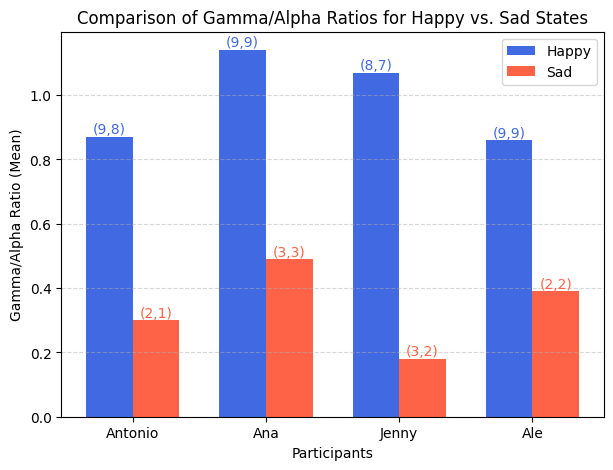

In [25]:
# # Plot data as a grouped bar plot

participants = ["Antonio", "Ana", "Jenny", "Ale"]
happy_means = [0.87, 1.14, 1.07, 0.86]
sad_means = [0.30, 0.49, 0.18, 0.39]

# Valence-arousal values for each participant and state
happy_valence_arousal = ["(9,8)", "(9,9)", "(8,7)", "(9,9)"]
sad_valence_arousal = ["(2,1)", "(3,3)", "(3,2)", "(2,2)"]

x_labels = participants
x = np.arange(len(participants))

fig, ax = plt.subplots(figsize=(7,5))
bar_width = 0.35

happy_bars = ax.bar(x - bar_width/2, happy_means, bar_width, label='Happy', color='royalblue')
sad_bars = ax.bar(x + bar_width/2, sad_means, bar_width, label='Sad', color='tomato')

# Add valence-arousal text above bars
for i, (happy_bar, sad_bar) in enumerate(zip(happy_bars, sad_bars)):
    ax.text(happy_bar.get_x() + happy_bar.get_width() / 2, happy_bar.get_height() + 0.01, 
            happy_valence_arousal[i], ha='center', fontsize=10, color='royalblue')
    ax.text(sad_bar.get_x() + sad_bar.get_width() / 2, sad_bar.get_height() + 0.01, 
            sad_valence_arousal[i], ha='center', fontsize=10, color='tomato')

ax.set_xlabel("Participants")
ax.set_ylabel("Gamma/Alpha Ratio (Mean)")
ax.set_title("Comparison of Gamma/Alpha Ratios for Happy vs. Sad States")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()



# Plotting Gamma/Alpha Ratio for all Videos

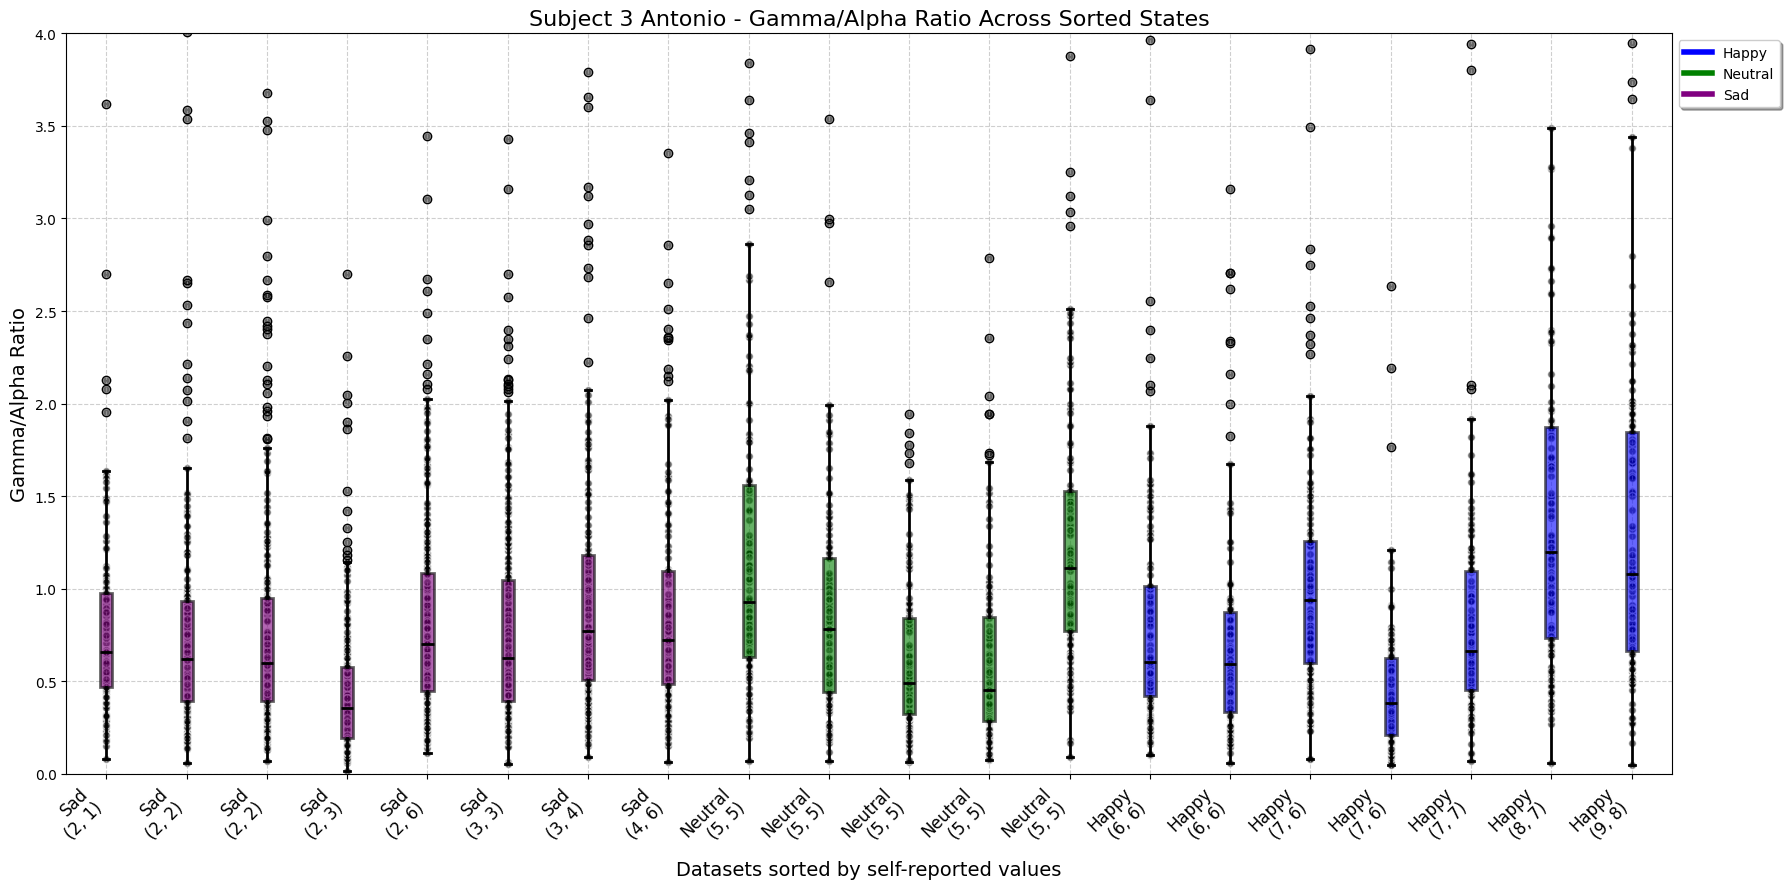

In [ ]:
antonio_filenames_sr = {
    'Happy': {'filenames': ['Erotic_1.txt','Erotic_2.txt','Erotic_3.txt',
                            'Erotic_4.txt','Erotic_5.txt','Erotic_6.txt','Erotic_7.txt'],
        'self_reports': [(6,6),(7,7),(8,7),(7,6),(9,8),(6,6),(7,6)]},
        
    'Neutral': {'filenames': ['Neutral_1.txt','Neutral_2.txt','Neutral_4.txt',
                              'Neutral_5.txt','Neutral_7.txt'],
        'self_reports': [(5,5),(5,5),(5,5),(5,5),(5,5)]},

    'Sad': {'filenames': ['Sadness_1.txt','Sadness_2.txt','Sadness_3.txt','Sadness_4.txt','Sadness_5.txt',
                          'Sadness_6.txt','Sadness_7.txt','Sadness_8.txt'],
        'self_reports': [(2,3),(3,4),(4,6),(2,6),(2,2),(2,2),(2,1),(3,3)]}
}


def process_eeg_spg(file_folder, filenames):
    gamma_alpha_ratios = []

    fs = 200
    freq_ranges = {
        'alpha1': [8, 10],
        'alpha2': [10, 12],
        'gamma2': [38, 46],
    }
    
    epsilon = 1e-10  # Small constant to prevent division by zero

    for filename in filenames:
        data = load_data(f'/Users/hhafizi/Documents/AWEAR/Data Files/{file_folder}/{filename}')
        
        # Remove first and last 10 seconds of data
        data = data[:, 2560:-2560]  

        # Clean data using z-score thresholding
        cleaned_data = np.array([
            np.interp(np.arange(len(ch)), np.arange(len(ch))[abs(ch - np.mean(ch)) <= 2 * np.std(ch)], ch[abs(ch - np.mean(ch)) <= 2 * np.std(ch)])
            for ch in data
        ])

        # Apply bandpass filter
        filt_coef = signal.firwin(numtaps=(int(3*fs/4)), cutoff=(4, 55), fs=fs, pass_zero=False)
        filtered_data = signal.lfilter(filt_coef, 1.0, cleaned_data, axis=-1)

        # Extract right mastoid electrode
        right_mastoid = filtered_data[0, :]

        # Compute STFT
        f_spg, t_spg, spg = signal.spectrogram(right_mastoid, fs=fs, nperseg=int(fs), noverlap=int(fs*0.25))

        # Extract power values for each band
        band_powers = {}
        for band, (f_min, f_max) in freq_ranges.items():
            band_mask = np.logical_and(f_spg >= f_min, f_spg <= f_max)
            band_powers[band] = np.mean(np.abs(spg[band_mask]), axis=0)  

        # Compute gamma/alpha ratio over time
        alpha_power = np.mean([band_powers['alpha1'], band_powers['alpha2']], axis=0)
        gamma_alpha_ratio = band_powers['gamma2']/(alpha_power+epsilon)
        #gamma_alpha_ratio = gamma_power/(alpha_power + epsilon) 

        #gamma_alpha_ratios.append(gamma_alpha_ratio)
        gamma_alpha_ratios.append(gamma_alpha_ratio)

    return gamma_alpha_ratios

def plot_gamma_alpha_ratios_sorted(participant_data, participant_name):
    plt.figure(figsize=(18, 9))  

    all_ratios = []
    all_labels = []

    # Prepare data sorted by self reported values
    sorted_data = []
    for state, data in participant_data.items():
        for filename, sr in zip(data['filenames'], data['self_reports']):
            sorted_data.append((filename, sr, state))
    
    # Sort by self reported valence and arousal
    sorted_data.sort(key=lambda x: (x[1][0], x[1][1]))

    # Process each dataset in sorted order
    for idx, (filename, self_report, state) in enumerate(sorted_data):
        ratios = process_eeg_spg('Subject 3 Antonio', [filename])
        

        all_ratios.append(ratios[0])
        all_labels.append(f"{state}\n{self_report}")


        plt.boxplot(ratios[0], positions=[idx + 1], patch_artist=True, 
                    boxprops=dict(facecolor='blue' if state == 'Happy' else 
                                  'green' if state == 'Neutral' else 'purple', alpha=0.6, linewidth=2),
                    whiskerprops={'linewidth': 2},
                    capprops={'linewidth': 2},
                    medianprops={'linewidth': 2, 'color': 'black'})


        plt.scatter([idx + 1] * len(ratios[0]), ratios[0], color='black', alpha=0.6, s=30, edgecolors='white')


    plt.xlabel('Datasets sorted by self-reported values', fontsize=14)
    plt.ylabel('Gamma/Alpha Ratio', fontsize=14)
    plt.ylim([0,4])
    plt.title(f'{participant_name} - Gamma/Alpha Ratio Across Sorted States', fontsize=16)
    plt.xticks(range(1, len(all_labels) + 1), all_labels, rotation=45, ha='right', fontsize=12)
    

    legend_elements = [
        plt.Line2D([0], [0], color='blue', lw=4, label='Happy'),
        plt.Line2D([0], [0], color='green', lw=4, label='Neutral'),
        plt.Line2D([0], [0], color='purple', lw=4, label='Sad')
    ]
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1),shadow=True)

    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    
    plt.show()

plot_gamma_alpha_ratios_sorted(antonio_filenames_sr, 'Subject 3 Antonio')


# Appendix

Creating First Algorithm Based on Gamma/Alpha Ratio
Idea: 

-High arousal state
if Gamma2 > 50%
   if Gamma2/Alpha > 66%
      you are happy
   else
      you are tense

-Low arousal state
else
   if Gamma2/Alpha < 33%
      you are sad
   else
      you are relaxed

In [29]:

# def GARA(file_folder,filename):
    
#     #Gamma-Alpha Ratio Algorithm
  

#     # Create data file to store state eeg data
#     data = {
#         'State':[]
#             }

#     # Load Data
#     for state, _ in data.items():
#         data[state] = load_data(f'D:/AWEAR/Data Files/{file_folder}/{filename}')

#     # Remove first and last 10 seconds of data
#     data_cleaned = {state : dataset[state][:,int(10*256):int(dataset.shape[1]-10*256)] for state,dataset in data.items()} 

#     for state, dataset in data_cleaned.items():
#         for i, ch in enumerate(dataset):
#             mask = abs(ch - np.mean(ch)) > 2 * np.std(ch) 
            
#             indices = np.arange(len(ch)) 
#             ch_cleaned = np.copy(ch)
#             ch_cleaned[mask] = np.interp(indices[mask], indices[~mask], ch[~mask])
            
#             data_cleaned[state][i] = ch_cleaned

#     # # Set sampling frequency
#     fs = 256

#     # Apply a bandpass filter between 4-60 Hz to data
#     filt_coef = signal.firwin(numtaps=(int(3*fs/4)), cutoff=(4,55), fs=fs, pass_zero=False)

#     # # Filter data
#     for state, dataset in data_cleaned.items():
#         data_cleaned[state] = signal.lfilter(filt_coef,1.0,dataset, axis=-1)

#     # Extract only right mastoid electrode
#     data_rm = {state : data_cleaned[state][0,:] for state in data_cleaned.keys()}

#     # Calculate average band power across all sub-bands
#     freq_ranges = {
#         'theta':[4,8],
#         'alpha1':[8,10],
#         'alpha2':[10,12],
#         'beta1':[12,18],
#         'beta2':[18,24],
#         'beta3':[24,30],
#         'gamma1':[30,38],
#         'gamma2':[38,46],
#         'gamma3':[46,54]
#         }

#     # state_data = {
#     #     'State':[]
#     #         }
    
#     subject_state_avg_power = {state: {} for state in data_rm.keys()}

#     # Loop through each state 
#     for state, dat in data_rm.items():
       
#        # Obtain the PSD values for right mastoid channel in each state
#        f_psd, psd = signal.welch(x=dat,nperseg=int(fs),noverlap=int(fs*0.25),fs=fs)

#        # Loop through frequency band ranges and obtain mean power for each band in the current state
#        for band, (f_min, f_max) in freq_ranges.items():     
#             band_mask = np.logical_and(f_psd >= f_min, f_psd <= f_max)
#             subject_state_avg_power[state][band] = psd[band_mask].mean()  

#     # Calculate band power ratios
#     band_power_ratios = calc_band_power_ratios(avg_band_power)

#     gamma2_value = [avg_band_power[state]['gamma2'] for state in avg_band_power.keys()]
#     gamma2_alpha_value = [band_power_ratios[state]['gamma2/alpha'] for state in band_power_ratios.keys()]

#     if gamma2_value
    


################################################################################################################


# antonio_filenames_sr = {
#     'Happy': {'filenames': ['Erotic_1.txt','Erotic_2.txt','Erotic_3.txt',
#                             'Erotic_4.txt','Erotic_5.txt','Erotic_6.txt','Erotic_7.txt'],
#         'self_reports': [(6,6),(7,7),(8,7),(7,6),(9,8),(6,6),(7,6)]},
        
#     'Neutral': {'filenames': ['Neutral_1.txt','Neutral_2.txt','Neutral_4.txt',
#                               'Neutral_5.txt','Neutral_7.txt'],
#         'self_reports': [(5,5),(5,5),(5,5),(5,5),(5,5)]},

#     'Sad': {'filenames': ['Sadness_1.txt','Sadness_2.txt','Sadness_3.txt','Sadness_4.txt','Sadness_5.txt',
#                           'Sadness_6.txt','Sadness_7.txt','Sadness_8.txt'],
#         'self_reports': [(2,3),(3,4),(4,6),(2,6),(2,2),(2,2),(2,1),(3,3)]}
# }

# # Function to process data and compute gamma/alpha ratios
# def process_eeg(file_folder, filenames):
#     gamma_alpha_ratios = []
    
#     for filename in filenames:
#         data = load_data(f'D:/AWEAR/Data Files/{file_folder}/{filename}')
        
#         # Remove first and last 10 seconds of data
#         data = data[:, 2560:-2560]  
        
#         # Clean data
#         cleaned_data = np.array([
#             np.interp(np.arange(len(ch)), np.arange(len(ch))[abs(ch - np.mean(ch)) <= 2 * np.std(ch)], ch[abs(ch - np.mean(ch)) <= 2 * np.std(ch)])
#             for ch in data
#         ])
        
        
#         # Apply bandpass filter
#         fs = 256
#         filt_coef = signal.firwin(numtaps=(int(3*fs/4)), cutoff=(4, 55), fs=fs, pass_zero=False)
#         filtered_data = signal.lfilter(filt_coef, 1.0, cleaned_data, axis=-1)
        
#         # INdex right mastoid electrode 
#         right_mastoid = filtered_data[0, :]
        
#         # Compute psd
#         f_psd, psd = signal.welch(right_mastoid, fs=fs, nperseg=fs, noverlap=int(fs * 0.25))

#         # Frequency bands
#         freq_ranges = {
#             'alpha1':[8,10],
#             'alpha2':[10,12],
#             'gamma1':[30,38],
#             'gamma2':[38,46],
#             'gamma3':[46,54]
#         }
        
#         # Compute mean power for alpha and gamma bands
#         alpha1_power = np.mean(psd[(f_psd >= freq_ranges['alpha1'][0]) & (f_psd <= freq_ranges['alpha1'][1])])
#         alpha2_power = np.mean(psd[(f_psd >= freq_ranges['alpha2'][0]) & (f_psd <= freq_ranges['alpha2'][1])])
#         gamma1_power = np.mean(psd[(f_psd >= freq_ranges['gamma1'][0]) & (f_psd <= freq_ranges['gamma1'][1])])
#         gamma2_power = np.mean(psd[(f_psd >= freq_ranges['gamma2'][0]) & (f_psd <= freq_ranges['gamma2'][1])])
#         gamma3_power = np.mean(psd[(f_psd >= freq_ranges['gamma3'][0]) & (f_psd <= freq_ranges['gamma3'][1])])

#         alpha_power = np.mean([alpha1_power,alpha2_power])
#         gamma_power = np.mean([gamma1_power,gamma2_power,gamma3_power])
        
#         # Compute gamma/alpha ratio
#         gamma_alpha_ratios.append(np.mean([gamma_power/alpha_power,gamma1_power/alpha_power,
#                                            gamma2_power/alpha_power,gamma3_power/alpha_power]))

#     return gamma_alpha_ratios

# def plot_gamma_alpha_ratios(participant_data, participant_name):
#     plt.figure(figsize=(10, 6))

#     state_colors = {'Happy': 'blue', 'Neutral': 'green', 'Sad': 'purple'}
#     positions = [1, 2, 3]  
#     all_ratios = []
#     all_labels = []

#     for idx, state in enumerate(participant_data):
#         data = participant_data[state] 
#         ratios = process_eeg('Subject 3 Antonio', data['filenames'])
#         self_reports = data['self_reports']
        
#         all_ratios.append(ratios)
#         labels = [f"({val},{aro})" for val, aro in self_reports]
#         all_labels.extend(labels)

#         # Boxplot 
#         plt.boxplot(ratios, positions=[positions[idx]], patch_artist=True,
#                     boxprops=dict(facecolor=state_colors[state], alpha=0.5), labels=[state])

#         # Scatter plot of self-reports with aligned color
#         jitter = np.random.normal(0, 0.05, len(ratios))  # Adding jitter to avoid overlap
#         plt.scatter(np.array([positions[idx]] * len(ratios)) + jitter, ratios,
#                     color=state_colors[state], label='Self-Report Values' if idx == 0 else "")

#         for i, (x, y) in enumerate(zip([positions[idx]] * len(ratios), ratios)):
#             vert_offset = 0.02 * (i % 3 - 1) 
#             horiz_offset = 0.03 * (-1) ** i  
#             plt.annotate(labels[i], (x + jitter[i] + horiz_offset, y + vert_offset),
#                          fontsize=8, ha='left', va='bottom')

   
#     plt.xlabel('Emotional State')
#     plt.ylabel('Gamma/Alpha Ratio')
#     plt.title(f'{participant_name} - Gamma/Alpha Ratio Across States')
#     plt.xticks(positions, ['Happy', 'Neutral', 'Sad'])
    
#     # Add self-report values to legend outside the plot
#     handles = [plt.Line2D([0], [0], marker='o', color=color, linestyle='None', markersize=8, label=state) 
#                for state, color in state_colors.items()]
    
#     plt.legend(handles=handles, loc='upper left', bbox_to_anchor=(1, 1)) 
    
#     plt.grid(True)
#     plt.show()

# plot_gamma_alpha_ratios(antonio_filenames_sr, 'Subject 3 Antonio')

    